# Systematic Statistical Significance Testing

This notebook tests for statistical significance in a systematic manner.

In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import pingouin as pg

from Functions.st_import_merge_and_validate_final_evals import import_merge_and_validate_final_evals
from Functions.st_custom_prauc_rce_display import custom_prauc_rce_display
from Functions.repeated_loc import repeated_loc
from Functions.pp_remove_duplicates_and_inconsistencies import remove_duplicates_and_inconsistencies
from Functions.st_get_common_factor_combinations import get_common_factor_combinations
from Functions.pp_flatten_deflatten import deflatten_evals, flatten_evals
from Functions.st_loc_by_dict import loc_by_dict
from Functions.st_run_multiple_friedman_tests import run_multiple_friedman_tests
from Functions.st_run_multiple_multicomp_corrections import run_multiple_multicomp_corrections
from Functions.st_run_multiple_pairwise_tests import run_multiple_pairwise_tests

# Importing Evaluations

For a step-by-step elaboration of what evaluations we have and why we are looking at them in this manner, cf. ```Statistics-02-EvaluationStatisticsAndPreliminaryTests```.

In [2]:
# If on the TU Wien's LBD cluster use yarn, otherwise use local
working_on_cluster = "adbs20" in os.path.abspath(os.getcwd())
ALL_ENGS = ["like", "reply", "retweet", "quote", "react"]
TARGET_COL = "target"  # column name in the flattened form describing whose values are individual tweet engagement goals (ignored if FLATTEN_RESULTS = False)
EVAL_COL = "evaluation"  # column name in the flattened form describing with an individual evaluation value (ignored if FLATTEN_RESULTS = False)
DEV_PREFIX = "dev-"
DATA_TO_BE_CONSIDERED = "combined-"  # can be None or "dev"- to only consider locally produced data, "" to only consider cluster data or "combined-" to consider both

# General setings
CALCULATE_STEPS = True # calculate inbetween steps - provides more transparent progress, but might slow down the run

# Evaluation names
ABSOLUTE_PATH_PREFIX  = "/home/adbs20/e01528091/Master/2020recsystwitter" if working_on_cluster else os.path.abspath(os.path.join("", os.pardir))  # https://prnt.sc/ZaFbM7LWTDbg
CLASSIFIER_NAMES = ["tree", "lr", "svc", "bayes", "forest", "GradientBoosting"]
FEATURES_NOTES = ["oracle_scaled", "scaled", "oracle_unscaled", "unscaled",]  # should be a subset values of dict <FEATURES_SELECTION_TO_FEATURES_NOTE_MAP> that represents the order in which the featuresets are to be processed; set to None to process all in the order given in <FEATURES_SELECTION_TO_FEATURES_NOTE_MAP>
TRAINED_ONS = ["itself", "train"]  # whether fitted on the corresponding train dataset instead of the same dataset
SORTING_ORDER = ["trained_on", "algorithm", "note", "feature_selection", "evaluated_on", ]

# Evals settings
FINAL_EVALS_FOLDER = os.path.join(ABSOLUTE_PATH_PREFIX, "Results", "Eval", "Final")
FINAL_PRAUC_FILENAME = "final-prauc.csv"
FINAL_RCE_FILENAME = "final-rce.csv"
FINAL_STATISTICAL_SIGNIFICANCE_FOLDER = os.path.join(ABSOLUTE_PATH_PREFIX, "Results", "StatisticalSignificance")

Evals did not have to be (de)flattened.
(De)flattenig needed: for flatten=True, flatten_statuses={'prauc_evals': False, 'rce_evals': False}
Flattened dict_keys(['prauc_evals', 'rce_evals'])
Shapes of PRAUC/RCE at start: (72650, 7)/(74375, 7), 
after removing duplicates: (59990, 7)/(61595, 7) (kept best), 
and after removing inconsistencies=(59690, 7)/(59690, 7).
Evals did not have to be (de)flattened.
____17.05.2023 20:43:50____

Read final evals for _PRAUC of shape (59690, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (59690, 13), of that non-nans for evaluation=58105.
Present algorithms in _PRAUC


evaluations
algorithm                    
bayes                   20760
forest                  18855
tree                    10309
GradientBoosting         8531
lr                        870
svc                       365

Present notes in _PRAUC


evaluations
note                      
scaled               56540
oracle_scaled         3150

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                      22995
top_10                    9935
top_25                    9070
top_5                     9010
top_50                    8680

Present trained_ons in _PRAUC


evaluations
trained_on                                    
train_EU_sample_1pct                      6104
train_EU_sample_10pct                     4500
train_EWU_sample_2pct                     2560
train_EU_sample_2pct                      2560
train_EWU_sample_1pct                     2525
train_inter_EWU+EU_sample_1pct            2485
train_random_sample_1pct                  2480
train_inter_EWU+EU_sample_2pct            2275
test_random_sample_1pct                   2125
train_random_sample_2pct                  2065
train_EU_sample_5pct                      1600
train_EWU_sample_5pct                     1600
train_tweet_sample_2pct                   1540
test_random_sample_2pct                   1365
train_tweet_sample_1pct                   1315
test_inter_EWU+EU_sample_1pct             1305
train_EWU_sample_10pct                    1205
train_inter_EWU+EU_sample_10pct           1200
test_EU_sample_2pct                       1175
test_EWU_sample_2pct                      1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
train_random_sample_5pct                   790
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
train_tweet_sample_5pct                    400
train_random_sample_10pct                  400
train_inter_EWU+EU_sample_5pct             400
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
train_tweet_sample_10pct                   300
val_EU_sample_2pct                         300
val_EWU_sample_2pct                        300
val+test_EWU_sample_2pct                   300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_random_sample_10pct                     75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_5pct                      75
val_EU_sample_5pct                          75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val_inter_EWU+EU_sample_1pct               2125
val+test_tweet_sample_1pct                 2125
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EWU_sample_1pct                        2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_inter_EWU+EU_sample_1pct              2085
test_EWU_sample_1pct                       2085
val+test_EU_sample_1pct                    2065
test_EU_sample_1pct                        2065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_random_sample_2pct                1065
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
test_tweet_sample_5pct                      505
val+test_tweet_sample_5pct                  505
val+test_random_sample_5pct                 505
val+test_inter_EWU+EU_sample_5pct           505
val_random_sample_5pct                      505
val_tweet_sample_5pct                       505
val_inter_EWU+EU_sample_5pct                505
test_random_sample_5pct                     505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
test_random_sample_10pct                    505
val+test_random_sample_10pct                490
val+test_EU_sample_5pct                     485
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
test_EU_sample_5pct                         485
val+test_EWU_sample_5pct                    485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val_EU_sample_10pct                         360
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
test                                        325
val+test                                    325
val                                         325
train_random_sample_1pct                    200
train_EWU_sample_1pct                       125
train_random_sample_2pct                    115
train_inter_EWU+EU_sample_2pct              115
train_inter_EWU+EU_sample_1pct              115
train_EU_sample_1pct                        104
train_EWU_sample_2pct                       100
train_EWU_sample_5pct                       100
train_EU_sample_5pct                        100
train_EU_sample_2pct                        100
train_inter_EWU+EU_sample_5pct              100
train_random_sample_10pct                   100
train_random_sample_5pct                    100
train_tweet_sample_1pct                     100
train_tweet_sample_2pct                     100
train_tweet_sample_5pct                     100
train_EWU_sample_10pct                       80
train_inter_EWU+EU_sample_10pct              75
train_EU_sample_10pct                        75
trai

Present to_datasets in _PRAUC


evaluations
to_dataset             
train             38304
test              12490
val+test           5286
val                3610

Present to_techniques in _PRAUC


evaluations
to_technique             
EU                  19424
random              12061
EWU                 11765
inter_EWU+EU        10615
tweet                5825

Present to_percents in _PRAUC


evaluations
to_percent             
1pct              25635
2pct              20110
10pct              8030
5pct               5915

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020
train              2079

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random              13756
tweet               11360
inter_EWU+EU        11320
EWU                 11315
EU                  10964
full                  975

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct              32910
2pct              11170
5pct               7955
10pct              6680
full                975

algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817



____17.05.2023 20:43:51____

Read final evals for _RCE of shape (59690, 13) for data_to_be_cosidered=combined-.
_RCE shape: (59690, 13), of that non-nans for evaluation=58105.
Present algorithms in _RCE


evaluations
algorithm                    
bayes                   20760
forest                  18855
tree                    10309
GradientBoosting         8531
lr                        870
svc                       365

Present notes in _RCE


evaluations
note                      
scaled               56540
oracle_scaled         3150

Present feature_selections in _RCE


evaluations
feature_selection             
all                      22995
top_10                    9935
top_25                    9070
top_5                     9010
top_50                    8680

Present trained_ons in _RCE


evaluations
trained_on                                    
train_EU_sample_1pct                      6104
train_EU_sample_10pct                     4500
train_EWU_sample_2pct                     2560
train_EU_sample_2pct                      2560
train_EWU_sample_1pct                     2525
train_inter_EWU+EU_sample_1pct            2485
train_random_sample_1pct                  2480
train_inter_EWU+EU_sample_2pct            2275
test_random_sample_1pct                   2125
train_random_sample_2pct                  2065
train_EU_sample_5pct                      1600
train_EWU_sample_5pct                     1600
train_tweet_sample_2pct                   1540
test_random_sample_2pct                   1365
train_tweet_sample_1pct                   1315
test_inter_EWU+EU_sample_1pct             1305
train_EWU_sample_10pct                    1205
train_inter_EWU+EU_sample_10pct           1200
test_EU_sample_2pct                       1175
test_EWU_sample_2pct                      1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
train_random_sample_5pct                   790
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
train_tweet_sample_5pct                    400
train_random_sample_10pct                  400
train_inter_EWU+EU_sample_5pct             400
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
train_tweet_sample_10pct                   300
val_EU_sample_2pct                         300
val_EWU_sample_2pct                        300
val+test_EWU_sample_2pct                   300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_random_sample_10pct                     75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_5pct                      75
val_EU_sample_5pct                          75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

Present evaluated_ons in _RCE


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val_inter_EWU+EU_sample_1pct               2125
val+test_tweet_sample_1pct                 2125
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EWU_sample_1pct                        2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_inter_EWU+EU_sample_1pct              2085
test_EWU_sample_1pct                       2085
val+test_EU_sample_1pct                    2065
test_EU_sample_1pct                        2065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_random_sample_2pct                1065
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
test_tweet_sample_5pct                      505
val+test_tweet_sample_5pct                  505
val+test_random_sample_5pct                 505
val+test_inter_EWU+EU_sample_5pct           505
val_random_sample_5pct                      505
val_tweet_sample_5pct                       505
val_inter_EWU+EU_sample_5pct                505
test_random_sample_5pct                     505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
test_random_sample_10pct                    505
val+test_random_sample_10pct                490
val+test_EU_sample_5pct                     485
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
test_EU_sample_5pct                         485
val+test_EWU_sample_5pct                    485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val_EU_sample_10pct                         360
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
test                                        325
val+test                                    325
val                                         325
train_random_sample_1pct                    200
train_EWU_sample_1pct                       125
train_random_sample_2pct                    115
train_inter_EWU+EU_sample_2pct              115
train_inter_EWU+EU_sample_1pct              115
train_EU_sample_1pct                        104
train_EWU_sample_2pct                       100
train_EWU_sample_5pct                       100
train_EU_sample_5pct                        100
train_EU_sample_2pct                        100
train_inter_EWU+EU_sample_5pct              100
train_random_sample_10pct                   100
train_random_sample_5pct                    100
train_tweet_sample_1pct                     100
train_tweet_sample_2pct                     100
train_tweet_sample_5pct                     100
train_EWU_sample_10pct                       80
train_inter_EWU+EU_sample_10pct              75
train_EU_sample_10pct                        75
trai

Present to_datasets in _RCE


evaluations
to_dataset             
train             38304
test              12490
val+test           5286
val                3610

Present to_techniques in _RCE


evaluations
to_technique             
EU                  19424
random              12061
EWU                 11765
inter_EWU+EU        10615
tweet                5825

Present to_percents in _RCE


evaluations
to_percent             
1pct              25635
2pct              20110
10pct              8030
5pct               5915

Present eo_datasets in _RCE


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020
train              2079

Present eo_techniques in _RCE


C:\Users\Jovan\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


evaluations
eo_technique             
random              13756
tweet               11360
inter_EWU+EU        11320
EWU                 11315
EU                  10964
full                  975

Present eo_percents in _RCE


evaluations
eo_percent             
1pct              32910
2pct              11170
5pct               7955
10pct              6680
full                975

algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target   evaluation  
0      10pct     like -1352.785472  
1      10pct    reply  -643.912756  
2      10pct  retweet  -949.838046  
3      10pct    quote  -479.297808  
4      10pct    react -1345.101797

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target   evaluation  
0      10pct     like -1352.785472  
1      10pct    reply  -643.912756  
2      10pct  retweet  -949.838046  
3      10pct    quote  -479.297808  
4      10pct    react -1345.101797

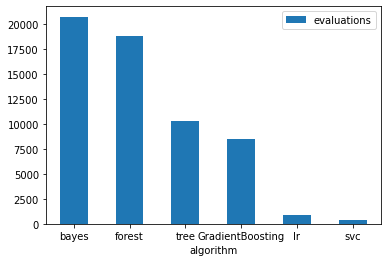

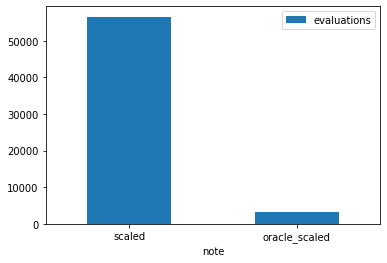

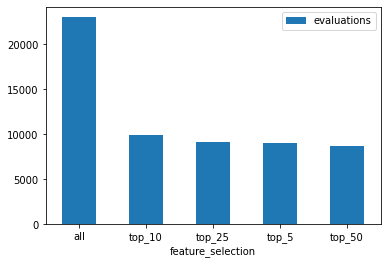

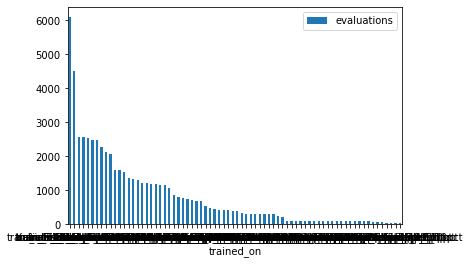

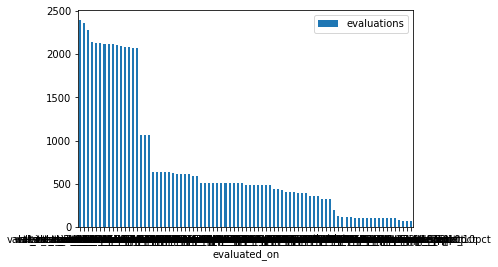

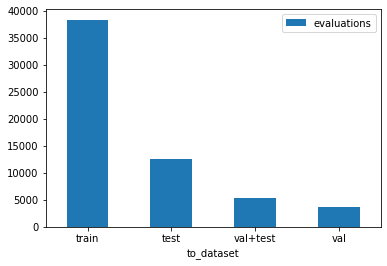

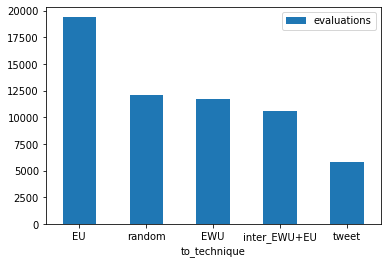

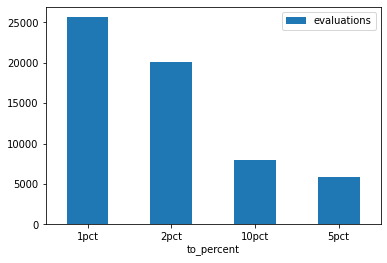

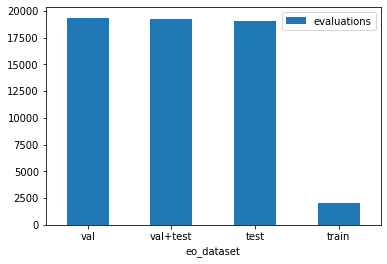

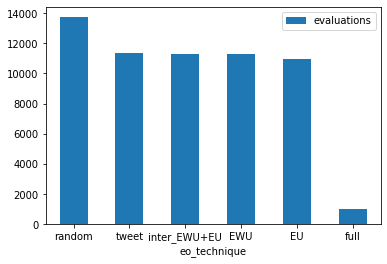

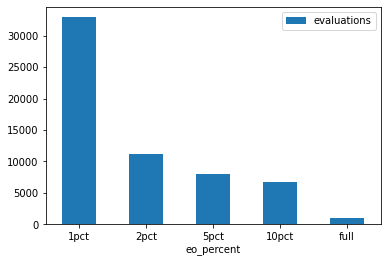

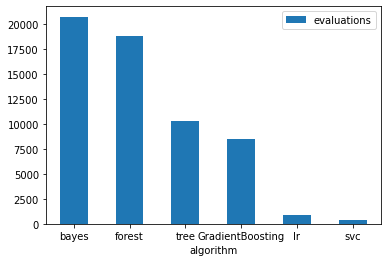

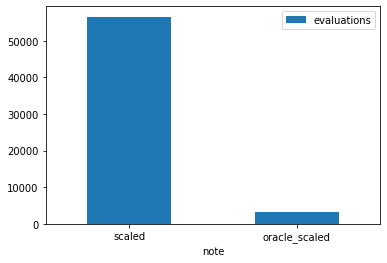

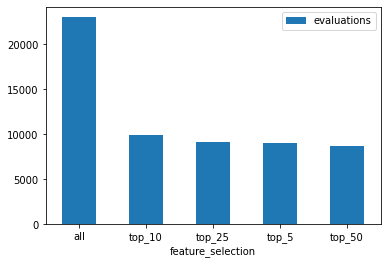

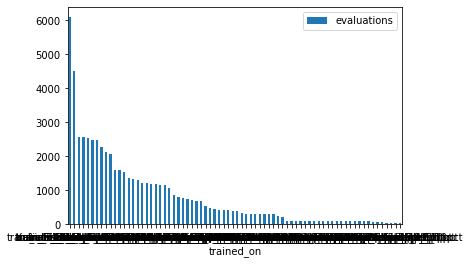

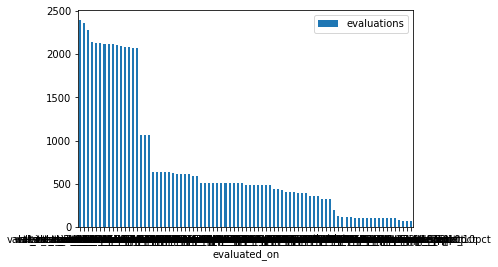

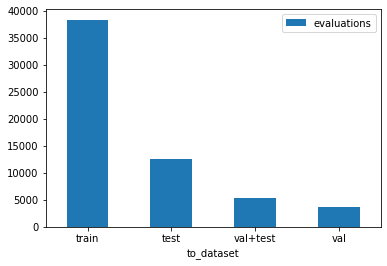

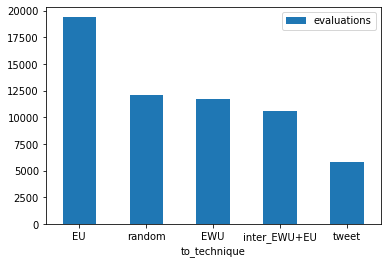

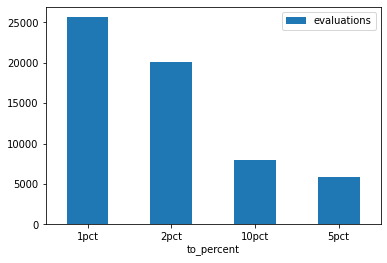

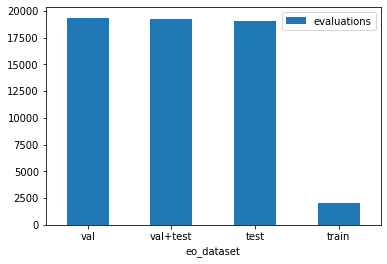

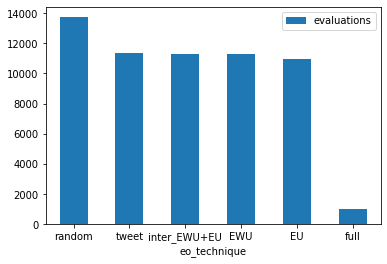

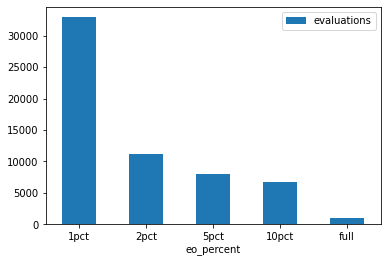

In [3]:
prauc, rce = import_merge_and_validate_final_evals(data_to_be_cosidered=DATA_TO_BE_CONSIDERED,
                                      final_evals_folder=FINAL_EVALS_FOLDER, 
                                      final_prauc_filename=FINAL_PRAUC_FILENAME, 
                                      final_rce_filename=FINAL_RCE_FILENAME, 
                                      dev_prefix=DEV_PREFIX,
                                      all_engs=ALL_ENGS, 
                                      eval_col=EVAL_COL, 
                                      flatten=True,
                                      sorting_order=SORTING_ORDER,
                                      keep="best",
                                      print_progress=CALCULATE_STEPS,)
custom_prauc_rce_display(prauc, rce, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

### Finding common factors for eval_all

Now we found balanced data for all factors, as was shown in ```Statistics-02-EvaluationStatisticsAndPreliminaryTests```.

____17.05.2023 20:43:55____

Read final evals for _PRAUC of shape (35790, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (35790, 13), of that non-nans for evaluation=35357.
Present algorithms in _PRAUC


evaluations
algorithm                    
forest                  10890
bayes                    9930
GradientBoosting         7680
tree                     7290

Present notes in _PRAUC


evaluations
note                      
scaled               35190
oracle_scaled          600

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                      14550
top_10                    5385
top_25                    5385
top_5                     5385
top_50                    5085

Present trained_ons in _PRAUC


evaluations
trained_on                                  
train_EU_sample_1pct                    6000
train_EU_sample_10pct                   4425
train_EWU_sample_2pct                   2460
train_EU_sample_2pct                    2460
train_inter_EWU+EU_sample_1pct          2370
train_EWU_sample_1pct                   2280
train_inter_EWU+EU_sample_2pct          2160
train_random_sample_1pct                1965
train_random_sample_2pct                1950
train_EWU_sample_5pct                   1500
train_EU_sample_5pct                    1500
train_tweet_sample_2pct                 1440
train_tweet_sample_1pct                 1215
train_inter_EWU+EU_sample_10pct         1125
train_EWU_sample_10pct                  1125
train_random_sample_5pct                 690
train_inter_EWU+EU_sample_5pct           300
train_random_sample_10pct                300
train_tweet_sample_5pct                  300
train_tweet_sample_10pct                 225

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
test_tweet_sample_1pct                     1070
val+test_tweet_sample_1pct                 1070
val_tweet_sample_1pct                      1070
test_EWU_sample_1pct                       1065
val_inter_EWU+EU_sample_1pct               1065
val+test_EWU_sample_1pct                   1065
test_inter_EWU+EU_sample_1pct              1065
val+test_inter_EWU+EU_sample_1pct          1065
val_EWU_sample_1pct                        1065
val+test_EU_sample_1pct                    1050
val_EU_sample_1pct                         1050
test_EU_sample_1pct                        1050
val_random_sample_1pct                     1045
test_random_sample_1pct                    1045
val+test_random_sample_1pct                1045
val_random_sample_2pct                      585
test_random_sample_2pct                     585
val+test_random_sample_2pct                 585
val+test_random_sample_10pct                430
val+test_inter_EWU+EU_sample_5pct           430
val+test_tweet_sample_2pct                  430
val+test_tweet_sample_5pct                  430
val_tweet_sample_5pct                       430
test_inter_EWU+EU_sample_5pct               430
test_random_sample_10pct                    430
val_tweet_sample_2pct                       430
val_random_sample_5pct                      430
val_random_sample_10pct                     430
val_inter_EWU+EU_sample_5pct                430
val+test_random_sample_5pct                 430
test_random_sample_5pct                     430
test_tweet_sample_2pct                      430
test_tweet_sample_5pct                      430
test_inter_EWU+EU_sample_2pct               415
val_inter_EWU+EU_sample_2pct                415
val+test_inter_EWU+EU_sample_2pct           415
val_EWU_sample_2pct                         410
val_EU_sample_2pct                          410
val_EU_sample_5pct                          410
val_EWU_sample_5pct                         410
val+test_EWU_sample_5pct                    410
test_EWU_sample_5pct                        410
val+test_EWU_sample_2pct                    410
test_EU_sample_2pct                         410
val+test_EU_sample_5pct                     410
test_EU_sample_5pct                         410
val+test_EU_sample_2pct                     410
test_EWU_sample_2pct                        410
val+test_tweet_sample_10pct                 405
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val_inter_EWU+EU_sample_10pct               390
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
test_EWU_sample_10pct                       390
val_EWU_sample_10pct                        390
val+test_EWU_sample_10pct                   390
val+test_EU_sample_10pct                    335
val_EU_sample_10pct                         335
test_EU_sample_10pct                        335
val                                         325
val+test                                    325
test                                        325

Present to_datasets in _PRAUC


evaluations
to_dataset             
train             35790

Present to_techniques in _PRAUC


evaluations
to_technique             
EU                  14385
EWU                  7365
inter_EWU+EU         5955
random               4905
tweet                3180

Present to_percents in _PRAUC


evaluations
to_percent             
1pct              13830
2pct              10470
10pct              7200
5pct               4290

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
test              11930
val+test          11930
val               11930

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random               7470
tweet                7005
inter_EWU+EU         6900
EWU                  6825
EU                   6615
full                  975

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct              15885
2pct               6750
5pct               6330
10pct              5850
full                975

algorithm    note feature_selection             trained_on to_dataset  \
12490     bayes  scaled               all  train_EU_sample_10pct      train   
12491     bayes  scaled               all  train_EU_sample_10pct      train   
12492     bayes  scaled               all  train_EU_sample_10pct      train   
12493     bayes  scaled               all  train_EU_sample_10pct      train   
12494     bayes  scaled               all  train_EU_sample_10pct      train   

      to_technique to_percent          evaluated_on eo_dataset eo_technique  \
12490           EU      10pct  test_EU_sample_10pct       test           EU   
12491           EU      10pct  test_EU_sample_10pct       test           EU   
12492           EU      10pct  test_EU_sample_10pct       test           EU   
12493           EU      10pct  test_EU_sample_10pct       test           EU   
12494           EU      10pct  test_EU_sample_10pct       test           EU   

      eo_percent   target  evaluation  
12490      10pct     like    0.679306  
12491      10pct    reply    0.368943  
12492      10pct  retweet    0.433508  
12493      10pct    quote    0.295560  
12494      10pct    react    0.719809

________



algorithm    note feature_selection             trained_on to_dataset  \
12490     bayes  scaled               all  train_EU_sample_10pct      train   
12491     bayes  scaled               all  train_EU_sample_10pct      train   
12492     bayes  scaled               all  train_EU_sample_10pct      train   
12493     bayes  scaled               all  train_EU_sample_10pct      train   
12494     bayes  scaled               all  train_EU_sample_10pct      train   

      to_technique to_percent          evaluated_on eo_dataset eo_technique  \
12490           EU      10pct  test_EU_sample_10pct       test           EU   
12491           EU      10pct  test_EU_sample_10pct       test           EU   
12492           EU      10pct  test_EU_sample_10pct       test           EU   
12493           EU      10pct  test_EU_sample_10pct       test           EU   
12494           EU      10pct  test_EU_sample_10pct       test           EU   

      eo_percent   target  evaluation  
12490      10pct     like    0.679306  
12491      10pct    reply    0.368943  
12492      10pct  retweet    0.433508  
12493      10pct    quote    0.295560  
12494      10pct    react    0.719809

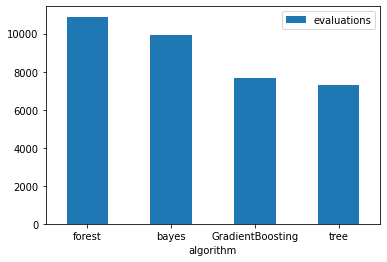

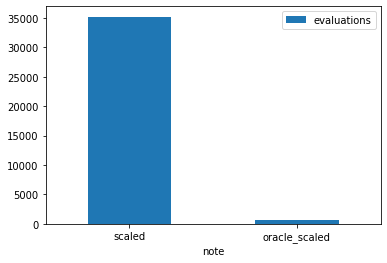

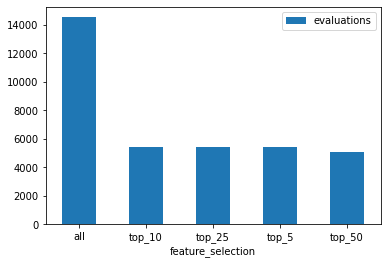

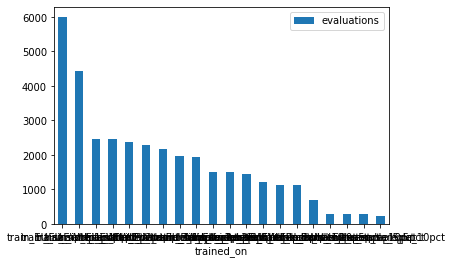

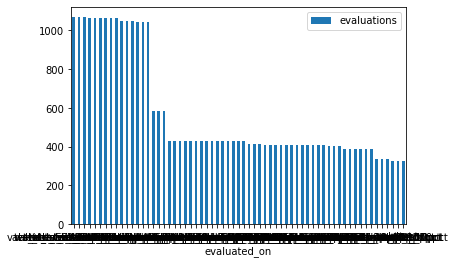

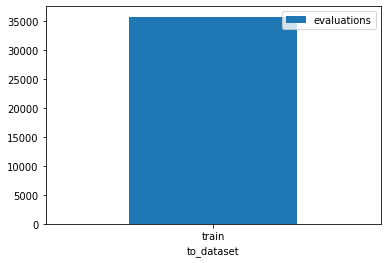

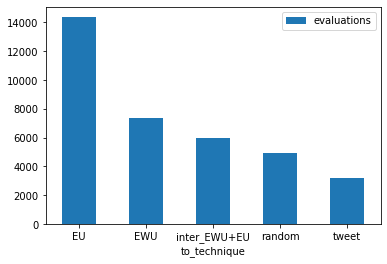

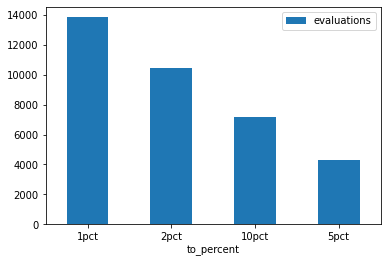

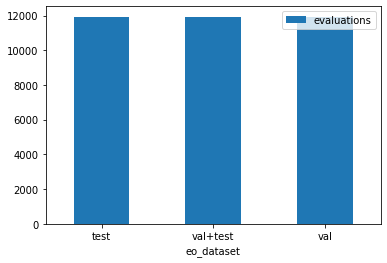

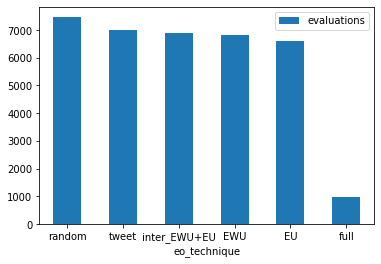

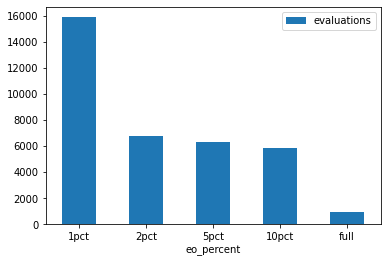

In [4]:
# https://prnt.sc/baA8bojyEWrc
loc_dict_r1 = {
    "algorithm": ["bayes", "forest", "tree", "GradientBoosting",],
    "to_dataset": ['train',],
    "eo_dataset": ["val", "test", "val+test",],
}

prauc_r1 = loc_by_dict(prauc, filters=loc_dict_r1)
rce_r1 = loc_by_dict(prauc, filters=loc_dict_r1)
custom_prauc_rce_display(prauc_r1, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

In [5]:
r1_prauc_dict_paired, r1_prauc_counts = get_common_factor_combinations(prauc_r1, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
r1_rce_dict_paired, r1_rce_counts = get_common_factor_combinations(rce_r1, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
df = r1_prauc_dict_paired["evaluated_on"]["react"]
r1_prauc_counts

factor        calculated_dt  \
0             algorithm  17.05.2023 20:43:58   
1                  note  17.05.2023 20:43:59   
2     feature_selection  17.05.2023 20:44:00   
3            trained_on  17.05.2023 20:44:02   
4            to_dataset  17.05.2023 20:44:03   
5          to_technique  17.05.2023 20:44:05   
6            to_percent  17.05.2023 20:44:06   
7          evaluated_on  17.05.2023 20:44:08   
8                target  17.05.2023 20:44:09   
9  all factors combined  17.05.2023 20:44:11   

                                              values  common_counts  like  \
0            [GradientBoosting, bayes, forest, tree]          19308  3912   
1                            [oracle_scaled, scaled]           1200   240   
2               [all, top_10, top_25, top_5, top_50]          23320  4785   
3                                                 []              0     0   
4                                            [train]          35357  7158   
5                                                 []              0     0   
6                                                 []              0     0   
7  [test, test_EU_sample_10pct, test_EU_sample_1p...          19908  4095   
8               [like, reply, retweet, quote, react]          34435  6887   
9                               all factors combined              0     0   

   reply  retweet  quote  react  
0   3876     3840   3840   3840  
1    240      240    240    240  
2   4730     4710   4700   4395  
3      0        0      0      0  
4   7135     7100   7076   6888  
5      0        0      0      0  
6      0        0      0      0  
7   3969     3969   3969   3906  
8   6887     6887   6887   6887  
9      0        0      0      0

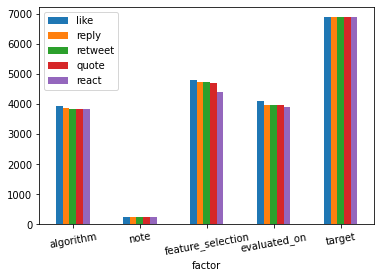

In [6]:
common_factors_plt = r1_rce_counts.loc[(r1_rce_counts["values"].str.len() != 0) & (r1_rce_counts["factor"] != "to_dataset") & (r1_rce_counts["factor"] != "all factors combined")].set_index("factor").plot.bar(y=["like",'reply',"retweet", "quote", "react"], rot=10).get_figure()
common_factors_plt.savefig(os.path.join(FINAL_STATISTICAL_SIGNIFICANCE_FOLDER, "Visualisations", "CommonFactors.png"))

In [7]:
withins = ["algorithm", "note", "feature_selection", "to_technique", "to_percent"]


for col in withins:
    s = f"{col} in r1 balanced for evaluated_on and react"
    print(s)
    cross_tab = pd.crosstab(index=df["evaluated_on"], columns=df[col],margins=False)
    print(cross_tab.sum())
    display(cross_tab.head(4))  # https://prnt.sc/on62TG6DPj6r, https://prnt.sc/f-7Q1Hbh5iG7
    if col in r1_rce_dict_paired.keys():
        s = f"{col} in r1 balanced for {col} and react"
        print(s)
        cross_tab = pd.crosstab(index=r1_rce_dict_paired[col]["react"]["evaluated_on"], columns=r1_rce_dict_paired[col]["react"][col], margins=False)
        print(cross_tab.sum()) 
        display(cross_tab.head(4))
    
    print("________________________________")

algorithm in r1 balanced for evaluated_on and react
algorithm
GradientBoosting     756
bayes               1134
forest              1071
tree                 945
dtype: int64


algorithm             GradientBoosting  bayes  forest  tree
evaluated_on                                               
test                                12     18      17    15
test_EU_sample_10pct                12     18      17    15
test_EU_sample_1pct                 12     18      17    15
test_EU_sample_2pct                 12     18      17    15

algorithm in r1 balanced for algorithm and react
algorithm
GradientBoosting    960
bayes               960
forest              960
tree                960
dtype: int64


algorithm             GradientBoosting  bayes  forest  tree
evaluated_on                                               
test                                10     10      10    10
test_EU_sample_10pct                10     10      10    10
test_EU_sample_1pct                 21     21      21    21
test_EU_sample_2pct                 14     14      14    14

________________________________
note in r1 balanced for evaluated_on and react
note
scaled    3906
dtype: int64


note                  scaled
evaluated_on                
test                      62
test_EU_sample_10pct      62
test_EU_sample_1pct       62
test_EU_sample_2pct       62

note in r1 balanced for note and react
note
oracle_scaled    120
scaled           120
dtype: int64


note                           oracle_scaled  scaled
evaluated_on                                        
test_EU_sample_1pct                        8       8
test_EWU_sample_1pct                       8       8
test_inter_EWU+EU_sample_1pct              8       8
test_random_sample_1pct                    8       8

________________________________
feature_selection in r1 balanced for evaluated_on and react
feature_selection
all       2205
top_10     441
top_25     441
top_5      441
top_50     378
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                   35       7       7      7       6
test_EU_sample_10pct   35       7       7      7       6
test_EU_sample_1pct    35       7       7      7       6
test_EU_sample_2pct    35       7       7      7       6

feature_selection in r1 balanced for feature_selection and react
feature_selection
all       879
top_10    879
top_25    879
top_5     879
top_50    879
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                    4       4       4      4       4
test_EU_sample_10pct    6       6       6      6       6
test_EU_sample_1pct    35      35      35     35      35
test_EU_sample_2pct     8       8       8      8       8

________________________________
to_technique in r1 balanced for evaluated_on and react
to_technique
EU              2520
EWU              945
inter_EWU+EU     441
dtype: int64


to_technique          EU  EWU  inter_EWU+EU
evaluated_on                               
test                  40   15             7
test_EU_sample_10pct  40   15             7
test_EU_sample_1pct   40   15             7
test_EU_sample_2pct   40   15             7

to_technique in r1 balanced for to_technique and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_percent in r1 balanced for evaluated_on and react
to_percent
10pct    1071
1pct     1701
2pct      630
5pct      504
dtype: int64


to_percent            10pct  1pct  2pct  5pct
evaluated_on                                 
test                     17    27    10     8
test_EU_sample_10pct     17    27    10     8
test_EU_sample_1pct      17    27    10     8
test_EU_sample_2pct      17    27    10     8

to_percent in r1 balanced for to_percent and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________


## Running Statistical Tests

We first run Friedman tests, then correct p values for multiple tests and then run the pairwise non-parametric tests.

In [8]:
test_results = run_multiple_friedman_tests(r1_prauc_dict_paired, r1_rce_dict_paired, withins=withins, try_balanced_on_subject_if_not_enough_values_in_balanced_on_within=True)
display(test_results.head())

test metric   target     within       subject balanced_on  \
0  Friedman  PRAUC     like  algorithm  evaluated_on   algorithm   
1  Friedman    RCE     like  algorithm  evaluated_on   algorithm   
2  Friedman  PRAUC    reply  algorithm  evaluated_on   algorithm   
3  Friedman    RCE    reply  algorithm  evaluated_on   algorithm   
4  Friedman  PRAUC  retweet  algorithm  evaluated_on   algorithm   

   balanced_on_within  instances  within_len  \
0                True       3912           4   
1                True       3912           4   
2                True       3876           4   
3                True       3876           4   
4                True       3840           4   

                               within_list  ...  within_max_fr  subject_len  \
0  [GradientBoosting, bayes, forest, tree]  ...            978           63   
1  [GradientBoosting, bayes, forest, tree]  ...            978           63   
2  [GradientBoosting, bayes, forest, tree]  ...            969           63   
3  [GradientBoosting, bayes, forest, tree]  ...            969           63   
4  [GradientBoosting, bayes, forest, tree]  ...            960           63   

                                        subject_list subject_min_fr  \
0  [val_tweet_sample_1pct, val+test_tweet_sample_...             40   
1  [val_tweet_sample_1pct, val+test_tweet_sample_...             40   
2  [val_tweet_sample_1pct, val+test_tweet_sample_...             40   
3  [val_tweet_sample_1pct, val+test_tweet_sample_...             40   
4  [test_tweet_sample_1pct, val+test_tweet_sample...             40   

   subject_max_fr     Source         W  ddof1           Q         p-unc  
0             100  algorithm  0.550920      3  104.123810  2.016646e-22  
1             100  algorithm  0.550920      3  104.123810  2.016646e-22  
2             100  algorithm  0.797833      3  150.790476  1.779275e-32  
3             100  algorithm  0.797833      3  150.790476  1.779275e-32  
4             100  algorithm  0.455581      3   86.104762  1.503145e-18  

[5 rows x 21 columns]

In [9]:
test_results_padjust = run_multiple_multicomp_corrections(test_results)
test_results_padjust.to_csv(os.path.join(FINAL_STATISTICAL_SIGNIFICANCE_FOLDER, "Friedman", "friedman-r1.csv"), index=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(test_results_padjust)

test metric   target             within       subject  \
0   Friedman  PRAUC     like          algorithm  evaluated_on   
1   Friedman    RCE     like          algorithm  evaluated_on   
2   Friedman  PRAUC    reply          algorithm  evaluated_on   
3   Friedman    RCE    reply          algorithm  evaluated_on   
4   Friedman  PRAUC  retweet          algorithm  evaluated_on   
5   Friedman    RCE  retweet          algorithm  evaluated_on   
6   Friedman  PRAUC    quote          algorithm  evaluated_on   
7   Friedman    RCE    quote          algorithm  evaluated_on   
8   Friedman  PRAUC    react          algorithm  evaluated_on   
9   Friedman    RCE    react          algorithm  evaluated_on   
10  Friedman  PRAUC     like               note  evaluated_on   
11  Friedman    RCE     like               note  evaluated_on   
12  Friedman  PRAUC    reply               note  evaluated_on   
13  Friedman    RCE    reply               note  evaluated_on   
14  Friedman  PRAUC  retweet               note  evaluated_on   
15  Friedman    RCE  retweet               note  evaluated_on   
16  Friedman  PRAUC    quote               note  evaluated_on   
17  Friedman    RCE    quote               note  evaluated_on   
18  Friedman  PRAUC    react               note  evaluated_on   
19  Friedman    RCE    react               note  evaluated_on   
20  Friedman  PRAUC     like  feature_selection  evaluated_on   
21  Friedman    RCE     like  feature_selection  evaluated_on   
22  Friedman  PRAUC    reply  feature_selection  evaluated_on   
23  Friedman    RCE    reply  feature_selection  evaluated_on   
24  Friedman  PRAUC  retweet  feature_selection  evaluated_on   
25  Friedman    RCE  retweet  feature_selection  evaluated_on   
26  Friedman  PRAUC    quote  feature_selection  evaluated_on   
27  Friedman    RCE    quote  feature_selection  evaluated_on   
28  Friedman  PRAUC    react  feature_selection  evaluated_on   
29  Friedman    RCE    react  feature_selection  evaluated_on   
30  Friedman  PRAUC     like       to_technique  evaluated_on   
31  Friedman    RCE     like       to_technique  evaluated_on   
32  Friedman  PRAUC    reply       to_technique  evaluated_on   
33  Friedman    RCE    reply       to_technique  evaluated_on   
34  Friedman  PRAUC  retweet       to_technique  evaluated_on   
35  Friedman    RCE  retweet       to_technique  evaluated_on   
36  Friedman  PRAUC    quote       to_technique  evaluated_on   
37  Friedman    RCE    quote       to_technique  evaluated_on   
38  Friedman  PRAUC    react       to_technique  evaluated_on   
39  Friedman    RCE    react       to_technique  evaluated_on   
40  Friedman  PRAUC     like         to_percent  evaluated_on   
41  Friedman    RCE     like         to_percent  evaluated_on   
42  Friedman  PRAUC    reply         to_percent  evaluated_on   
43  Friedman    RCE    reply         to_percent  evaluated_on   
44  Friedman  PRAUC  retweet         to_percent  evaluated_on   
45  Friedman    RCE  retweet         to_percent  evaluated_on   
46  Friedman  PRAUC    quote         to_percent  evaluated_on   
47  Friedman    RCE    quote         to_percent  evaluated_on   
48  Friedman  PRAUC    react         to_percent  evaluated_on   
49  Friedman    RCE    react         to_percent  evaluated_on   

          balanced_on  balanced_on_within  instances  within_len  \
0           algorithm                True       3912           4   
1           algorithm                True       3912           4   
2           algorithm                True       3876           4   
3           algorithm                True       3876           4   
4           algorithm                True       3840           4   
5           algorithm                True       3840           4   
6           algorithm                True       3840           4   
7           algorithm                True       3840           4   
8           algorithm                True       3840           4   
9           

In [10]:
test_results_padjust.loc[test_results_padjust["reject_H0"]].columns

Index(['test', 'metric', 'target', 'within', 'subject', 'balanced_on',
       'balanced_on_within', 'instances', 'within_len', 'within_list',
       'within_min_fr', 'within_max_fr', 'subject_len', 'subject_list',
       'subject_min_fr', 'subject_max_fr', 'Source', 'W', 'ddof1', 'Q',
       'p-unc', 'multicomp_padjust_method', 'alpha', 'p-corr', 'reject_H0'],
      dtype='object')

In [11]:
columns_to_be_exported = ['metric', 'target', 'within', 'balanced_on', 'W', 'ddof1', 'Q', 'p-corr']
tex_filename = os.path.join(FINAL_STATISTICAL_SIGNIFICANCE_FOLDER, "Friedman", "friedman-r1-pos.tex")
to_tex_pos = test_results_padjust.loc[test_results_padjust["reject_H0"]][columns_to_be_exported].rename(columns={"balanced_on":"balanced on",})
to_tex_pos.style.format(precision=4, escape="latex").hide(axis="index").to_latex(tex_filename, hrules=True,
                                                                                 caption="Results of the Friedman tests for individual facotrs where \texttt{p-corr}$<0.05$",
                                                                                 environment="longtable",
                                                                                 label=f"tabFriedmanPos",
                                                                                 position="ht")
print(to_tex_pos.shape)
to_tex_pos

(40, 8)


metric   target             within        balanced on         W  ddof1  \
0   PRAUC     like          algorithm          algorithm  0.550920      3   
1     RCE     like          algorithm          algorithm  0.550920      3   
2   PRAUC    reply          algorithm          algorithm  0.797833      3   
3     RCE    reply          algorithm          algorithm  0.797833      3   
4   PRAUC  retweet          algorithm          algorithm  0.455581      3   
5     RCE  retweet          algorithm          algorithm  0.455581      3   
6   PRAUC    quote          algorithm          algorithm  0.527450      3   
7     RCE    quote          algorithm          algorithm  0.527450      3   
8   PRAUC    react          algorithm          algorithm  0.528143      3   
9     RCE    react          algorithm          algorithm  0.528143      3   
10  PRAUC     like               note               note  1.000000      1   
11    RCE     like               note               note  1.000000      1   
20  PRAUC     like  feature_selection  feature_selection  0.630889      4   
21    RCE     like  feature_selection  feature_selection  0.630889      4   
22  PRAUC    reply  feature_selection  feature_selection  0.604334      4   
23    RCE    reply  feature_selection  feature_selection  0.604334      4   
24  PRAUC  retweet  feature_selection  feature_selection  0.717712      4   
25    RCE  retweet  feature_selection  feature_selection  0.717712      4   
26  PRAUC    quote  feature_selection  feature_selection  0.159079      4   
27    RCE    quote  feature_selection  feature_selection  0.159079      4   
28  PRAUC    react  feature_selection  feature_selection  0.439809      4   
29    RCE    react  feature_selection  feature_selection  0.439809      4   
30  PRAUC     like       to_technique       evaluated_on  0.653313      2   
31    RCE     like       to_technique       evaluated_on  0.653313      2   
34  PRAUC  retweet       to_technique       evaluated_on  0.662132      2   
35    RCE  retweet       to_technique       evaluated_on  0.662132      2   
36  PRAUC    quote       to_technique       evaluated_on  0.247522      2   
37    RCE    quote       to_technique       evaluated_on  0.247522      2   
38  PRAUC    react       to_technique       evaluated_on  0.535903      2   
39    RCE    react       to_technique       evaluated_on  0.535903      2   
40  PRAUC     like         to_percent       evaluated_on  0.516553      3   
41    RCE     like         to_percent       evaluated_on  0.516553      3   
42  PRAUC    reply         to_percent       evaluated_on  0.651197      3   
43    RCE    reply         to_percent       evaluated_on  0.651197      3   
44  PRAUC  retweet         to_percent       evaluated_on  0.704409      3   
45    RCE  retweet         to_percent       evaluated_on  0.704409      3   
46  PRAUC    quote         to_percent       evaluated_on  0.550626      3   
47    RCE    quote         to_percent       evaluated_on  0.550626      3   
48  PRAUC    react         to_percent       evaluated_on  0.510204      3   
49    RCE    react         to_percent       evaluated_on  0.510204      3   

             Q        p-corr  
0   104.123810  7.259924e-21  
1   104.123810  7.259924e-21  
2   150.790476  8.184666e-31  
3   150.790476  8.184666e-31  
4    86.104762  3.006290e-17  
5    86.104762  3.006290e-17  
6    99.688119  5.440964e-20  
7    99.688119  5.440964e-20  
8    99.819048  5.439428e-20  
9    99.819048  5.439428e-20  
10   15.000000  1.290134e-03  
11   15.000000  1.290134e-03  
20  158.984127  1.158857e-31  
21  158.984127  1.158857e-31  
22  152.292063  2.890446e-30  
23  152.292063  2.890446e-30  
24  180.863492  2.432533e-36  
25  180.863492  2.432533e-36  
26   40.087876  6.641639e-07  
27   40.087876  6.641639e-07  
28  110.831746  1.838133e-21  
29  110.831746  1.838133e-21  
30   82.317460  2.933684e-17  
31   82.317460  2.933684e-17  
34   83.428571  1.836230e-17  
35   83.428571  1.836230e-17  
36   31.

In [12]:
columns_to_be_exported = ['metric', 'target', 'within', 'balanced_on', 'W', 'ddof1', 'Q', 'p-corr']
tex_filename = os.path.join(FINAL_STATISTICAL_SIGNIFICANCE_FOLDER, "Friedman", "friedman-r1-neg.tex")
to_tex_neg = test_results_padjust.loc[~test_results_padjust["reject_H0"]][columns_to_be_exported].rename(columns={"balanced_on":"balanced on",})
to_tex_neg.style.format(precision=4, escape="latex").hide(axis="index").to_latex(tex_filename, hrules=True,
                                                                                 caption="Results of the Friedman tests for individual facotrs where \texttt{p-corr}$>0.05$",
                                                                                 environment="longtable",
                                                                                 label=f"tabFriedmanNeg",
                                                                                 position="ht")
print(to_tex_neg.shape)
to_tex_neg

(10, 8)


metric   target        within   balanced on         W  ddof1         Q  \
12  PRAUC    reply          note          note  0.005128      1  0.076923   
13    RCE    reply          note          note  0.005128      1  0.076923   
14  PRAUC  retweet          note          note  0.360000      1  5.400000   
15    RCE  retweet          note          note  0.360000      1  5.400000   
16  PRAUC    quote          note          note  0.066667      1  1.000000   
17    RCE    quote          note          note  0.066667      1  1.000000   
18  PRAUC    react          note          note  0.360000      1  5.400000   
19    RCE    react          note          note  0.360000      1  5.400000   
32  PRAUC    reply  to_technique  evaluated_on  0.019904      2  2.507937   
33    RCE    reply  to_technique  evaluated_on  0.019904      2  2.507937   

      p-corr  
12  1.000000  
13  1.000000  
14  0.201368  
15  0.201368  
16  1.000000  
17  1.000000  
18  0.201368  
19  0.201368  
32  1.000000  
33  1.000000

In [13]:
pairwise_test_results_dict = run_multiple_pairwise_tests(test_results_df=test_results_padjust,
                                                    prauc_cf_dic=r1_prauc_dict_paired, 
                                                    rce_cf_dic=r1_rce_dict_paired)

In [14]:
latex_inclusion_commands = ""

for key in pairwise_test_results_dict:
    print(key)
    csv_path = os.path.join(FINAL_STATISTICAL_SIGNIFICANCE_FOLDER, "PostHoc", "NonParmetricPairwise", key+".csv")
    pairwise_test_results_dict[key].to_csv(csv_path, index=False)
    tex_path = csv_path.replace("csv", "tex").replace(key, "SS-"+key)
    tex_columns = ["A", "B", "mean(A)", "mean(B)", "dof", "p-corr", "BF10", "hedges"]
    if "p-corr" in pairwise_test_results_dict[key].columns:
        tex_columns = ["A", "B", "mean(A)", "mean(B)", "dof", "p-corr", "BF10", "hedges"]
    else:
        tex_columns = ["A", "B", "mean(A)", "mean(B)", "dof", "p-unc", "BF10", "hedges"]
    split_key = key.split("-")
    tex_caption = f"Results of the post hoc Wilcoxon for {split_key[4]} and target {split_key[3]}".replace("_", "\_")
    pairwise_test_results_dict[key][tex_columns].style.format(precision=4, escape="latex")\
        .hide(axis="index").to_latex(tex_path,
                                     caption=tex_caption,
                                     environment="longtable",
                                     label="tab"+key,
                                     position="ht")
    latex_inclusion_commands += "\n\n" + "\input{Tables/StatisticalSignificance/pairwise/SS-" + key + "}"
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(pairwise_test_results_dict[key])

print(latex_inclusion_commands)

PostHoc-Friedman-PRAUC-like-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.623487  0.014559  0.582936   
1  algorithm  GradientBoosting  forest  0.623487  0.014559  0.636089   
2  algorithm  GradientBoosting    tree  0.623487  0.014559  0.617089   
3  algorithm             bayes  forest  0.582936  0.039844  0.636089   
4  algorithm             bayes    tree  0.582936  0.039844  0.617089   
5  algorithm            forest    tree  0.636089  0.021378  0.617089   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.039844    True      False   8.403477  62.0   two-sided  7.915656e-12   
1  0.021378    True      False  -6.136533  62.0   two-sided  6.533827e-08   
2  0.022600    True      False   2.870581  62.0   two-sided  5.598180e-03   
3  0.021378    True      False -11.557399  62.0   two-sided  4.142153e-17   
4  0.022600    True      False -11.056881  62.0   two-sided  2.666022e-16   
5  0.022600    True      False   7.229880  62.0   two-sided  8.594460e-10   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  3.166262e-11     holm  1.129e+09  1.343704       True  
1  1.306765e-07     holm  2.047e+05 -0.684854       True  
2  5.598180e-03     holm      5.698  0.334570       True  
3  2.485292e-16     holm  1.441e+14 -1.652353       True  
4  1.333011e-15     holm  2.366e+13 -1.048006       True  
5  2.578338e-09     holm  1.262e+07  0.858523       True

PostHoc-Friedman-RCE-like-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.623487  0.014559  0.582936   
1  algorithm  GradientBoosting  forest  0.623487  0.014559  0.636089   
2  algorithm  GradientBoosting    tree  0.623487  0.014559  0.617089   
3  algorithm             bayes  forest  0.582936  0.039844  0.636089   
4  algorithm             bayes    tree  0.582936  0.039844  0.617089   
5  algorithm            forest    tree  0.636089  0.021378  0.617089   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.039844    True      False   8.403477  62.0   two-sided  7.915656e-12   
1  0.021378    True      False  -6.136533  62.0   two-sided  6.533827e-08   
2  0.022600    True      False   2.870581  62.0   two-sided  5.598180e-03   
3  0.021378    True      False -11.557399  62.0   two-sided  4.142153e-17   
4  0.022600    True      False -11.056881  62.0   two-sided  2.666022e-16   
5  0.022600    True      False   7.229880  62.0   two-sided  8.594460e-10   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  3.166262e-11     holm  1.129e+09  1.343704       True  
1  1.306765e-07     holm  2.047e+05 -0.684854       True  
2  5.598180e-03     holm      5.698  0.334570       True  
3  2.485292e-16     holm  1.441e+14 -1.652353       True  
4  1.333011e-15     holm  2.366e+13 -1.048006       True  
5  2.578338e-09     holm  1.262e+07  0.858523       True

PostHoc-Friedman-PRAUC-reply-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.300656  0.064130  0.352518   
1  algorithm  GradientBoosting  forest  0.300656  0.064130  0.504338   
2  algorithm  GradientBoosting    tree  0.300656  0.064130  0.432681   
3  algorithm             bayes  forest  0.352518  0.042197  0.504338   
4  algorithm             bayes    tree  0.352518  0.042197  0.432681   
5  algorithm            forest    tree  0.504338  0.015896  0.432681   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.042197    True      False  -4.213984  62.0   two-sided  8.283566e-05   
1  0.015896    True      False -29.667883  62.0   two-sided  2.422382e-38   
2  0.051195    True      False -30.714289  62.0   two-sided  3.231778e-39   
3  0.015896    True      False -23.614810  62.0   two-sided  1.080278e-32   
4  0.051195    True      False  -7.350018  62.0   two-sided  5.318663e-10   
5  0.051195    True      False  13.763860  62.0   two-sided  1.635877e-20   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  8.283566e-05     holm    254.997 -0.949621       True  
1  1.211191e-37     holm  8.392e+34 -4.333313       True  
2  1.939067e-38     holm  6.063e+35 -2.261579       True  
3  4.321111e-32     holm  2.406e+29 -4.732736       True  
4  1.063733e-09     holm  1.997e+07 -1.698457       True  
5  4.907632e-20     holm  2.948e+17  1.878980       True

PostHoc-Friedman-RCE-reply-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.300656  0.064130  0.352518   
1  algorithm  GradientBoosting  forest  0.300656  0.064130  0.504338   
2  algorithm  GradientBoosting    tree  0.300656  0.064130  0.432681   
3  algorithm             bayes  forest  0.352518  0.042197  0.504338   
4  algorithm             bayes    tree  0.352518  0.042197  0.432681   
5  algorithm            forest    tree  0.504338  0.015896  0.432681   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.042197    True      False  -4.213984  62.0   two-sided  8.283566e-05   
1  0.015896    True      False -29.667883  62.0   two-sided  2.422382e-38   
2  0.051195    True      False -30.714289  62.0   two-sided  3.231778e-39   
3  0.015896    True      False -23.614810  62.0   two-sided  1.080278e-32   
4  0.051195    True      False  -7.350018  62.0   two-sided  5.318663e-10   
5  0.051195    True      False  13.763860  62.0   two-sided  1.635877e-20   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  8.283566e-05     holm    254.997 -0.949621       True  
1  1.211191e-37     holm  8.392e+34 -4.333313       True  
2  1.939067e-38     holm  6.063e+35 -2.261579       True  
3  4.321111e-32     holm  2.406e+29 -4.732736       True  
4  1.063733e-09     holm  1.997e+07 -1.698457       True  
5  4.907632e-20     holm  2.948e+17  1.878980       True

PostHoc-Friedman-PRAUC-retweet-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.288007  0.040117  0.355578   
1  algorithm  GradientBoosting  forest  0.288007  0.040117  0.325358   
2  algorithm  GradientBoosting    tree  0.288007  0.040117  0.307133   
3  algorithm             bayes  forest  0.355578  0.033695  0.325358   
4  algorithm             bayes    tree  0.355578  0.033695  0.307133   
5  algorithm            forest    tree  0.325358  0.042942  0.307133   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.033695    True      False  -9.503737  62.0   two-sided  1.026887e-13   
1  0.042942    True      False  -6.489356  62.0   two-sided  1.631942e-08   
2  0.032840    True      False  -4.024808  62.0   two-sided  1.576711e-04   
3  0.042942    True      False   5.148913  62.0   two-sided  2.872718e-06   
4  0.032840    True      False  11.258195  62.0   two-sided  1.256226e-16   
5  0.032840    True      False   4.163166  62.0   two-sided  9.860738e-05   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  5.134434e-13     holm  7.437e+10 -1.812965       True  
1  6.527767e-08     holm  7.635e+05 -0.893434       True  
2  1.972148e-04     holm    141.198 -0.518569       True  
3  8.618153e-06     holm   5793.671  0.778222       True  
4  7.537354e-16     holm   4.91e+13  1.447279       True  
5  1.972148e-04     holm    217.224  0.473884       True

PostHoc-Friedman-RCE-retweet-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.288007  0.040117  0.355578   
1  algorithm  GradientBoosting  forest  0.288007  0.040117  0.325358   
2  algorithm  GradientBoosting    tree  0.288007  0.040117  0.307133   
3  algorithm             bayes  forest  0.355578  0.033695  0.325358   
4  algorithm             bayes    tree  0.355578  0.033695  0.307133   
5  algorithm            forest    tree  0.325358  0.042942  0.307133   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.033695    True      False  -9.503737  62.0   two-sided  1.026887e-13   
1  0.042942    True      False  -6.489356  62.0   two-sided  1.631942e-08   
2  0.032840    True      False  -4.024808  62.0   two-sided  1.576711e-04   
3  0.042942    True      False   5.148913  62.0   two-sided  2.872718e-06   
4  0.032840    True      False  11.258195  62.0   two-sided  1.256226e-16   
5  0.032840    True      False   4.163166  62.0   two-sided  9.860738e-05   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  5.134434e-13     holm  7.437e+10 -1.812965       True  
1  6.527767e-08     holm  7.635e+05 -0.893434       True  
2  1.972148e-04     holm    141.198 -0.518569       True  
3  8.618153e-06     holm   5793.671  0.778222       True  
4  7.537354e-16     holm   4.91e+13  1.447279       True  
5  1.972148e-04     holm    217.224  0.473884       True

PostHoc-Friedman-PRAUC-quote-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.422981  0.074991  0.466107   
1  algorithm  GradientBoosting  forest  0.422981  0.074991  0.496533   
2  algorithm  GradientBoosting    tree  0.422981  0.074991  0.414833   
3  algorithm             bayes  forest  0.466107  0.028303  0.496533   
4  algorithm             bayes    tree  0.466107  0.028303  0.414833   
5  algorithm            forest    tree  0.496533  0.028643  0.414833   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.028303    True      False  -3.715970  62.0   two-sided  4.367054e-04   
1  0.028643    True      False -10.624994  62.0   two-sided  1.360770e-15   
2  0.050797    True      False   1.112864  62.0   two-sided  2.700632e-01   
3  0.028643    True      False  -5.216293  62.0   two-sided  2.233004e-06   
4  0.050797    True      False   5.946500  62.0   two-sided  1.370730e-07   
5  0.050797    True      False  13.346298  62.0   two-sided  6.873467e-20   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  8.734107e-04     holm     55.744 -0.756282       True  
1  6.803848e-15     holm  4.873e+12 -1.287922       True  
2  2.700632e-01     holm      0.249  0.126440      False  
3  6.699013e-06     holm   7335.731 -1.062116       True  
4  5.482921e-07     holm  1.015e+05  1.239421       True  
5  4.124080e-19     holm  7.281e+16  1.969293       True

PostHoc-Friedman-RCE-quote-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.422981  0.074991  0.466107   
1  algorithm  GradientBoosting  forest  0.422981  0.074991  0.496533   
2  algorithm  GradientBoosting    tree  0.422981  0.074991  0.414833   
3  algorithm             bayes  forest  0.466107  0.028303  0.496533   
4  algorithm             bayes    tree  0.466107  0.028303  0.414833   
5  algorithm            forest    tree  0.496533  0.028643  0.414833   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.028303    True      False  -3.715970  62.0   two-sided  4.367054e-04   
1  0.028643    True      False -10.624994  62.0   two-sided  1.360770e-15   
2  0.050797    True      False   1.112864  62.0   two-sided  2.700632e-01   
3  0.028643    True      False  -5.216293  62.0   two-sided  2.233004e-06   
4  0.050797    True      False   5.946500  62.0   two-sided  1.370730e-07   
5  0.050797    True      False  13.346298  62.0   two-sided  6.873467e-20   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  8.734107e-04     holm     55.744 -0.756282       True  
1  6.803848e-15     holm  4.873e+12 -1.287922       True  
2  2.700632e-01     holm      0.249  0.126440      False  
3  6.699013e-06     holm   7335.731 -1.062116       True  
4  5.482921e-07     holm  1.015e+05  1.239421       True  
5  4.124080e-19     holm  7.281e+16  1.969293       True

PostHoc-Friedman-PRAUC-react-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.685068  0.021707  0.644696   
1  algorithm  GradientBoosting  forest  0.685068  0.021707  0.692307   
2  algorithm  GradientBoosting    tree  0.685068  0.021707  0.671437   
3  algorithm             bayes  forest  0.644696  0.043073  0.692307   
4  algorithm             bayes    tree  0.644696  0.043073  0.671437   
5  algorithm            forest    tree  0.692307  0.019531  0.671437   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.043073    True      False   9.699111  62.0   two-sided  4.792480e-14   
1  0.019531    True      False  -3.959474  62.0   two-sided  1.962610e-04   
2  0.023621    True      False   5.722199  62.0   two-sided  3.264130e-07   
3  0.019531    True      False -10.242580  62.0   two-sided  5.862120e-15   
4  0.023621    True      False  -8.122428  62.0   two-sided  2.427100e-11   
5  0.023621    True      False   7.135158  62.0   two-sided  1.254358e-09   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  2.396240e-13     holm  1.553e+11  1.176534       True  
1  1.962610e-04     holm    115.556 -0.348502       True  
2  6.528260e-07     holm  4.475e+04  0.597240       True  
3  3.517272e-14     holm  1.185e+12 -1.415071       True  
4  9.708400e-11     holm  3.848e+08 -0.765177       True  
5  3.763075e-09     holm  8.797e+06  0.957136       True

PostHoc-Friedman-RCE-react-algorithm-evaluated_on-algorithm


Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.685068  0.021707  0.644696   
1  algorithm  GradientBoosting  forest  0.685068  0.021707  0.692307   
2  algorithm  GradientBoosting    tree  0.685068  0.021707  0.671437   
3  algorithm             bayes  forest  0.644696  0.043073  0.692307   
4  algorithm             bayes    tree  0.644696  0.043073  0.671437   
5  algorithm            forest    tree  0.692307  0.019531  0.671437   

     std(B)  Paired Parametric          T   dof alternative         p-unc  \
0  0.043073    True      False   9.699111  62.0   two-sided  4.792480e-14   
1  0.019531    True      False  -3.959474  62.0   two-sided  1.962610e-04   
2  0.023621    True      False   5.722199  62.0   two-sided  3.264130e-07   
3  0.019531    True      False -10.242580  62.0   two-sided  5.862120e-15   
4  0.023621    True      False  -8.122428  62.0   two-sided  2.427100e-11   
5  0.023621    True      False   7.135158  62.0   two-sided  1.254358e-09   

         p-corr p-adjust       BF10    hedges  reject_H0  
0  2.396240e-13     holm  1.553e+11  1.176534       True  
1  1.962610e-04     holm    115.556 -0.348502       True  
2  6.528260e-07     holm  4.475e+04  0.597240       True  
3  3.517272e-14     holm  1.185e+12 -1.415071       True  
4  9.708400e-11     holm  3.848e+08 -0.765177       True  
5  3.763075e-09     holm  8.797e+06  0.957136       True

PostHoc-Friedman-PRAUC-like-note-evaluated_on-note


Contrast              A       B   mean(A)    std(A)   mean(B)    std(B)  \
0     note  oracle_scaled  scaled  0.650154  0.019136  0.668139  0.018628   

   Paired Parametric          T   dof alternative         p-unc       BF10  \
0    True      False -15.635741  14.0   two-sided  2.935127e-10  2.953e+07   

     hedges  reject_H0  
0 -0.926687       True

PostHoc-Friedman-RCE-like-note-evaluated_on-note


Contrast              A       B   mean(A)    std(A)   mean(B)    std(B)  \
0     note  oracle_scaled  scaled  0.650154  0.019136  0.668139  0.018628   

   Paired Parametric          T   dof alternative         p-unc       BF10  \
0    True      False -15.635741  14.0   two-sided  2.935127e-10  2.953e+07   

     hedges  reject_H0  
0 -0.926687       True

PostHoc-Friedman-PRAUC-like-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.658817  0.023480  0.571779  0.025504   
1  feature_selection     all  top_25  0.658817  0.023480  0.613459  0.028313   
2  feature_selection     all   top_5  0.658817  0.023480  0.589786  0.015511   
3  feature_selection     all  top_50  0.658817  0.023480  0.602192  0.040398   
4  feature_selection  top_10  top_25  0.571779  0.025504  0.613459  0.028313   
5  feature_selection  top_10   top_5  0.571779  0.025504  0.589786  0.015511   
6  feature_selection  top_10  top_50  0.571779  0.025504  0.602192  0.040398   
7  feature_selection  top_25   top_5  0.613459  0.028313  0.589786  0.015511   
8  feature_selection  top_25  top_50  0.613459  0.028313  0.602192  0.040398   
9  feature_selection   top_5  top_50  0.589786  0.015511  0.602192  0.040398   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  19.642586  62.0   two-sided  2.599355e-28  2.339419e-27   
1    True      False  10.992573  62.0   two-sided  3.393823e-16  2.375676e-15   
2    True      False  19.725287  62.0   two-sided  2.075387e-28  2.075387e-27   
3    True      False  14.738412  62.0   two-sided  6.256941e-22  5.005553e-21   
4    True      False -10.036154  62.0   two-sided  1.297710e-14  7.786262e-14   
5    True      False  -9.552154  62.0   two-sided  8.499032e-14  4.249516e-13   
6    True      False  -5.320875  62.0   two-sided  1.507177e-06  4.521531e-06   
7    True      False   6.304013  62.0   two-sided  3.387806e-08  1.355122e-07   
8    True      False   3.028870  62.0   two-sided  3.575557e-03  7.151114e-03   
9    True      False  -2.326825  62.0   two-sided  2.325650e-02  2.325650e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.227e+25  3.529143       True  
1     holm  1.872e+13  1.733330       True  
2     holm  1.529e+25  3.448085       True  
3     holm  7.102e+18  1.703410       True  
4     holm  5.491e+11 -1.537487       True  
5     holm  8.928e+10 -0.847928       True  
6     holm  1.061e+04 -0.894817       True  
7     holm  3.816e+05  1.030765       True  
8     holm      8.454  0.321045       True  
9     holm      1.673 -0.402991       True

PostHoc-Friedman-RCE-like-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.658817  0.023480  0.571779  0.025504   
1  feature_selection     all  top_25  0.658817  0.023480  0.613459  0.028313   
2  feature_selection     all   top_5  0.658817  0.023480  0.589786  0.015511   
3  feature_selection     all  top_50  0.658817  0.023480  0.602192  0.040398   
4  feature_selection  top_10  top_25  0.571779  0.025504  0.613459  0.028313   
5  feature_selection  top_10   top_5  0.571779  0.025504  0.589786  0.015511   
6  feature_selection  top_10  top_50  0.571779  0.025504  0.602192  0.040398   
7  feature_selection  top_25   top_5  0.613459  0.028313  0.589786  0.015511   
8  feature_selection  top_25  top_50  0.613459  0.028313  0.602192  0.040398   
9  feature_selection   top_5  top_50  0.589786  0.015511  0.602192  0.040398   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  19.642586  62.0   two-sided  2.599355e-28  2.339419e-27   
1    True      False  10.992573  62.0   two-sided  3.393823e-16  2.375676e-15   
2    True      False  19.725287  62.0   two-sided  2.075387e-28  2.075387e-27   
3    True      False  14.738412  62.0   two-sided  6.256941e-22  5.005553e-21   
4    True      False -10.036154  62.0   two-sided  1.297710e-14  7.786262e-14   
5    True      False  -9.552154  62.0   two-sided  8.499032e-14  4.249516e-13   
6    True      False  -5.320875  62.0   two-sided  1.507177e-06  4.521531e-06   
7    True      False   6.304013  62.0   two-sided  3.387806e-08  1.355122e-07   
8    True      False   3.028870  62.0   two-sided  3.575557e-03  7.151114e-03   
9    True      False  -2.326825  62.0   two-sided  2.325650e-02  2.325650e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.227e+25  3.529143       True  
1     holm  1.872e+13  1.733330       True  
2     holm  1.529e+25  3.448085       True  
3     holm  7.102e+18  1.703410       True  
4     holm  5.491e+11 -1.537487       True  
5     holm  8.928e+10 -0.847928       True  
6     holm  1.061e+04 -0.894817       True  
7     holm  3.816e+05  1.030765       True  
8     holm      8.454  0.321045       True  
9     holm      1.673 -0.402991       True

PostHoc-Friedman-PRAUC-reply-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.439261  0.023608  0.346999  0.034189   
1  feature_selection     all  top_25  0.439261  0.023608  0.432223  0.033019   
2  feature_selection     all   top_5  0.439261  0.023608  0.395042  0.018472   
3  feature_selection     all  top_50  0.439261  0.023608  0.429309  0.054092   
4  feature_selection  top_10  top_25  0.346999  0.034189  0.432223  0.033019   
5  feature_selection  top_10   top_5  0.346999  0.034189  0.395042  0.018472   
6  feature_selection  top_10  top_50  0.346999  0.034189  0.429309  0.054092   
7  feature_selection  top_25   top_5  0.432223  0.033019  0.395042  0.018472   
8  feature_selection  top_25  top_50  0.432223  0.033019  0.429309  0.054092   
9  feature_selection   top_5  top_50  0.395042  0.018472  0.429309  0.054092   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  18.023042  62.0   two-sided  2.464081e-26  2.464081e-25   
1    True      False   1.613685  62.0   two-sided  1.116744e-01  3.350233e-01   
2    True      False  13.467871  62.0   two-sided  4.515062e-20  3.612049e-19   
3    True      False   1.390633  62.0   two-sided  1.693082e-01  3.386163e-01   
4    True      False -16.467627  62.0   two-sided  2.559473e-24  2.303525e-23   
5    True      False -13.039345  62.0   two-sided  2.002878e-19  1.402015e-18   
6    True      False -12.900637  62.0   two-sided  3.260372e-19  1.956223e-18   
7    True      False   8.951979  62.0   two-sided  8.983735e-13  4.491867e-12   
8    True      False   0.566912  62.0   two-sided  5.728208e-01  5.728208e-01   
9    True      False  -5.041400  62.0   two-sided  4.284054e-06  1.713621e-05   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.427e+23  3.121395       True  
1     holm       0.47  0.243735      False  
2     holm  1.096e+17  2.073557       True  
3     holm      0.344  0.237028      False  
4     holm  1.524e+21 -2.520372       True  
5     holm   2.57e+16 -1.737820       True  
6     holm    1.6e+16 -1.808048       True  
7     holm  9.176e+09  1.381352       True  
8     holm      0.161  0.064632      False  
9     holm   3986.271 -0.842682       True

PostHoc-Friedman-RCE-reply-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.439261  0.023608  0.346999  0.034189   
1  feature_selection     all  top_25  0.439261  0.023608  0.432223  0.033019   
2  feature_selection     all   top_5  0.439261  0.023608  0.395042  0.018472   
3  feature_selection     all  top_50  0.439261  0.023608  0.429309  0.054092   
4  feature_selection  top_10  top_25  0.346999  0.034189  0.432223  0.033019   
5  feature_selection  top_10   top_5  0.346999  0.034189  0.395042  0.018472   
6  feature_selection  top_10  top_50  0.346999  0.034189  0.429309  0.054092   
7  feature_selection  top_25   top_5  0.432223  0.033019  0.395042  0.018472   
8  feature_selection  top_25  top_50  0.432223  0.033019  0.429309  0.054092   
9  feature_selection   top_5  top_50  0.395042  0.018472  0.429309  0.054092   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  18.023042  62.0   two-sided  2.464081e-26  2.464081e-25   
1    True      False   1.613685  62.0   two-sided  1.116744e-01  3.350233e-01   
2    True      False  13.467871  62.0   two-sided  4.515062e-20  3.612049e-19   
3    True      False   1.390633  62.0   two-sided  1.693082e-01  3.386163e-01   
4    True      False -16.467627  62.0   two-sided  2.559473e-24  2.303525e-23   
5    True      False -13.039345  62.0   two-sided  2.002878e-19  1.402015e-18   
6    True      False -12.900637  62.0   two-sided  3.260372e-19  1.956223e-18   
7    True      False   8.951979  62.0   two-sided  8.983735e-13  4.491867e-12   
8    True      False   0.566912  62.0   two-sided  5.728208e-01  5.728208e-01   
9    True      False  -5.041400  62.0   two-sided  4.284054e-06  1.713621e-05   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.427e+23  3.121395       True  
1     holm       0.47  0.243735      False  
2     holm  1.096e+17  2.073557       True  
3     holm      0.344  0.237028      False  
4     holm  1.524e+21 -2.520372       True  
5     holm   2.57e+16 -1.737820       True  
6     holm    1.6e+16 -1.808048       True  
7     holm  9.176e+09  1.381352       True  
8     holm      0.161  0.064632      False  
9     holm   3986.271 -0.842682       True

PostHoc-Friedman-PRAUC-retweet-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.370994  0.037603  0.217028  0.053520   
1  feature_selection     all  top_25  0.370994  0.037603  0.311948  0.076055   
2  feature_selection     all   top_5  0.370994  0.037603  0.194636  0.041724   
3  feature_selection     all  top_50  0.370994  0.037603  0.265733  0.043874   
4  feature_selection  top_10  top_25  0.217028  0.053520  0.311948  0.076055   
5  feature_selection  top_10   top_5  0.217028  0.053520  0.194636  0.041724   
6  feature_selection  top_10  top_50  0.217028  0.053520  0.265733  0.043874   
7  feature_selection  top_25   top_5  0.311948  0.076055  0.194636  0.041724   
8  feature_selection  top_25  top_50  0.311948  0.076055  0.265733  0.043874   
9  feature_selection   top_5  top_50  0.194636  0.041724  0.265733  0.043874   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  21.121063  62.0   two-sided  5.141013e-30  4.626912e-29   
1    True      False   5.701862  62.0   two-sided  3.529845e-07  7.059690e-07   
2    True      False  24.481361  62.0   two-sided  1.431211e-33  1.431211e-32   
3    True      False  16.889610  62.0   two-sided  7.065182e-25  5.652145e-24   
4    True      False -11.552972  62.0   two-sided  4.210376e-17  2.947263e-16   
5    True      False   4.221433  62.0   two-sided  8.073948e-05  8.073948e-05   
6    True      False  -7.585842  62.0   two-sided  2.071994e-10  8.287975e-10   
7    True      False  10.998601  62.0   two-sided  3.317830e-16  1.990698e-15   
8    True      False   6.500685  62.0   two-sided  1.560515e-08  4.681546e-08   
9    True      False  -9.623604  62.0   two-sided  6.431265e-14  3.215633e-13   

  p-adjust       BF10    hedges  reject_H0  
0     holm  5.719e+26  3.308715       True  
1     holm  4.156e+04  0.978250       True  
2     holm  1.746e+30  4.413463       True  
3     holm  5.362e+21  2.560607       True  
4     holm  1.419e+14 -1.434683       True  
5     holm    261.085  0.463813       True  
6     holm  4.922e+07 -0.989255       True  
7     holm  1.914e+13  1.900896       True  
8     holm  7.966e+05  0.739871       True  
9     holm  1.169e+11 -1.650598       True

PostHoc-Friedman-RCE-retweet-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.370994  0.037603  0.217028  0.053520   
1  feature_selection     all  top_25  0.370994  0.037603  0.311948  0.076055   
2  feature_selection     all   top_5  0.370994  0.037603  0.194636  0.041724   
3  feature_selection     all  top_50  0.370994  0.037603  0.265733  0.043874   
4  feature_selection  top_10  top_25  0.217028  0.053520  0.311948  0.076055   
5  feature_selection  top_10   top_5  0.217028  0.053520  0.194636  0.041724   
6  feature_selection  top_10  top_50  0.217028  0.053520  0.265733  0.043874   
7  feature_selection  top_25   top_5  0.311948  0.076055  0.194636  0.041724   
8  feature_selection  top_25  top_50  0.311948  0.076055  0.265733  0.043874   
9  feature_selection   top_5  top_50  0.194636  0.041724  0.265733  0.043874   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  21.121063  62.0   two-sided  5.141013e-30  4.626912e-29   
1    True      False   5.701862  62.0   two-sided  3.529845e-07  7.059690e-07   
2    True      False  24.481361  62.0   two-sided  1.431211e-33  1.431211e-32   
3    True      False  16.889610  62.0   two-sided  7.065182e-25  5.652145e-24   
4    True      False -11.552972  62.0   two-sided  4.210376e-17  2.947263e-16   
5    True      False   4.221433  62.0   two-sided  8.073948e-05  8.073948e-05   
6    True      False  -7.585842  62.0   two-sided  2.071994e-10  8.287975e-10   
7    True      False  10.998601  62.0   two-sided  3.317830e-16  1.990698e-15   
8    True      False   6.500685  62.0   two-sided  1.560515e-08  4.681546e-08   
9    True      False  -9.623604  62.0   two-sided  6.431265e-14  3.215633e-13   

  p-adjust       BF10    hedges  reject_H0  
0     holm  5.719e+26  3.308715       True  
1     holm  4.156e+04  0.978250       True  
2     holm  1.746e+30  4.413463       True  
3     holm  5.362e+21  2.560607       True  
4     holm  1.419e+14 -1.434683       True  
5     holm    261.085  0.463813       True  
6     holm  4.922e+07 -0.989255       True  
7     holm  1.914e+13  1.900896       True  
8     holm  7.966e+05  0.739871       True  
9     holm  1.169e+11 -1.650598       True

PostHoc-Friedman-PRAUC-quote-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.476387  0.045546  0.473748  0.036524   
1  feature_selection     all  top_25  0.476387  0.045546  0.463458  0.023003   
2  feature_selection     all   top_5  0.476387  0.045546  0.452847  0.030930   
3  feature_selection     all  top_50  0.476387  0.045546  0.464173  0.026540   
4  feature_selection  top_10  top_25  0.473748  0.036524  0.463458  0.023003   
5  feature_selection  top_10   top_5  0.473748  0.036524  0.452847  0.030930   
6  feature_selection  top_10  top_50  0.473748  0.036524  0.464173  0.026540   
7  feature_selection  top_25   top_5  0.463458  0.023003  0.452847  0.030930   
8  feature_selection  top_25  top_50  0.463458  0.023003  0.464173  0.026540   
9  feature_selection   top_5  top_50  0.452847  0.030930  0.464173  0.026540   

   Paired Parametric         T   dof alternative     p-unc    p-corr p-adjust  \
0    True      False  0.448304  62.0   two-sided  0.655497  1.000000     holm   
1    True      False  1.810629  62.0   two-sided  0.075044  0.450264     holm   
2    True      False  3.765477  62.0   two-sided  0.000372  0.003720     holm   
3    True      False  1.780263  62.0   two-sided  0.079933  0.450264     holm   
4    True      False  1.745261  62.0   two-sided  0.085894  0.450264     holm   
5    True      False  3.735639  62.0   two-sided  0.000410  0.003720     holm   
6    True      False  1.463878  62.0   two-sided  0.148279  0.450264     holm   
7    True      False  2.753663  62.0   two-sided  0.007723  0.054058     holm   
8    True      False -0.337800  62.0   two-sided  0.736655  1.000000     holm   
9    True      False -2.883958  62.0   two-sided  0.005393  0.043145     holm   

     BF10    hedges  reject_H0  
0   0.152  0.063548      False  
1    0.64  0.356169      False  
2  64.497  0.601017       True  
3   0.609  0.325696      False  
4   0.576  0.335080      False  
5   59.06  0.613841       True  
6    0.38  0.298099      False  
7   4.303  0.386953      False  
8   0.146 -0.028611      False  
9   5.888 -0.390632       True

PostHoc-Friedman-RCE-quote-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.476387  0.045546  0.473748  0.036524   
1  feature_selection     all  top_25  0.476387  0.045546  0.463458  0.023003   
2  feature_selection     all   top_5  0.476387  0.045546  0.452847  0.030930   
3  feature_selection     all  top_50  0.476387  0.045546  0.464173  0.026540   
4  feature_selection  top_10  top_25  0.473748  0.036524  0.463458  0.023003   
5  feature_selection  top_10   top_5  0.473748  0.036524  0.452847  0.030930   
6  feature_selection  top_10  top_50  0.473748  0.036524  0.464173  0.026540   
7  feature_selection  top_25   top_5  0.463458  0.023003  0.452847  0.030930   
8  feature_selection  top_25  top_50  0.463458  0.023003  0.464173  0.026540   
9  feature_selection   top_5  top_50  0.452847  0.030930  0.464173  0.026540   

   Paired Parametric         T   dof alternative     p-unc    p-corr p-adjust  \
0    True      False  0.448304  62.0   two-sided  0.655497  1.000000     holm   
1    True      False  1.810629  62.0   two-sided  0.075044  0.450264     holm   
2    True      False  3.765477  62.0   two-sided  0.000372  0.003720     holm   
3    True      False  1.780263  62.0   two-sided  0.079933  0.450264     holm   
4    True      False  1.745261  62.0   two-sided  0.085894  0.450264     holm   
5    True      False  3.735639  62.0   two-sided  0.000410  0.003720     holm   
6    True      False  1.463878  62.0   two-sided  0.148279  0.450264     holm   
7    True      False  2.753663  62.0   two-sided  0.007723  0.054058     holm   
8    True      False -0.337800  62.0   two-sided  0.736655  1.000000     holm   
9    True      False -2.883958  62.0   two-sided  0.005393  0.043145     holm   

     BF10    hedges  reject_H0  
0   0.152  0.063548      False  
1    0.64  0.356169      False  
2  64.497  0.601017       True  
3   0.609  0.325696      False  
4   0.576  0.335080      False  
5   59.06  0.613841       True  
6    0.38  0.298099      False  
7   4.303  0.386953      False  
8   0.146 -0.028611      False  
9   5.888 -0.390632       True

PostHoc-Friedman-PRAUC-react-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.706542  0.025543  0.636651  0.041184   
1  feature_selection     all  top_25  0.706542  0.025543  0.664534  0.041717   
2  feature_selection     all   top_5  0.706542  0.025543  0.663807  0.032521   
3  feature_selection     all  top_50  0.706542  0.025543  0.672871  0.036505   
4  feature_selection  top_10  top_25  0.636651  0.041184  0.664534  0.041717   
5  feature_selection  top_10   top_5  0.636651  0.041184  0.663807  0.032521   
6  feature_selection  top_10  top_50  0.636651  0.041184  0.672871  0.036505   
7  feature_selection  top_25   top_5  0.664534  0.041717  0.663807  0.032521   
8  feature_selection  top_25  top_50  0.664534  0.041717  0.672871  0.036505   
9  feature_selection   top_5  top_50  0.663807  0.032521  0.672871  0.036505   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  11.750355  62.0   two-sided  2.036955e-17  1.833259e-16   
1    True      False   7.660927  62.0   two-sided  1.534613e-10  8.741591e-10   
2    True      False   7.673918  62.0   two-sided  1.456932e-10  8.741591e-10   
3    True      False   7.542369  62.0   two-sided  2.465356e-10  9.861424e-10   
4    True      False  -8.082434  62.0   two-sided  2.847239e-11  1.993067e-10   
5    True      False -12.957739  62.0   two-sided  2.667000e-19  2.667000e-18   
6    True      False -11.019841  62.0   two-sided  3.063483e-16  2.450786e-15   
7    True      False   0.193283  62.0   two-sided  8.473689e-01  8.473689e-01   
8    True      False  -3.562496  62.0   two-sided  7.130242e-04  2.139073e-03   
9    True      False  -2.430499  62.0   two-sided  1.798494e-02  3.596989e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm  2.871e+14  2.027201       True  
1     holm  6.562e+07  1.207139       True  
2     holm  6.897e+07  1.452648       True  
3     holm  4.168e+07  1.062277       True  
4     holm  3.301e+08 -0.668602       True  
5     holm  1.945e+16 -0.727411       True  
6     holm  2.068e+13 -0.925121       True  
7     holm      0.141  0.019334      False  
8     holm     35.753 -0.211407       True  
9     holm      2.079 -0.260622       True

PostHoc-Friedman-RCE-react-feature_selection-evaluated_on-feature_selection


Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.706542  0.025543  0.636651  0.041184   
1  feature_selection     all  top_25  0.706542  0.025543  0.664534  0.041717   
2  feature_selection     all   top_5  0.706542  0.025543  0.663807  0.032521   
3  feature_selection     all  top_50  0.706542  0.025543  0.672871  0.036505   
4  feature_selection  top_10  top_25  0.636651  0.041184  0.664534  0.041717   
5  feature_selection  top_10   top_5  0.636651  0.041184  0.663807  0.032521   
6  feature_selection  top_10  top_50  0.636651  0.041184  0.672871  0.036505   
7  feature_selection  top_25   top_5  0.664534  0.041717  0.663807  0.032521   
8  feature_selection  top_25  top_50  0.664534  0.041717  0.672871  0.036505   
9  feature_selection   top_5  top_50  0.663807  0.032521  0.672871  0.036505   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  11.750355  62.0   two-sided  2.036955e-17  1.833259e-16   
1    True      False   7.660927  62.0   two-sided  1.534613e-10  8.741591e-10   
2    True      False   7.673918  62.0   two-sided  1.456932e-10  8.741591e-10   
3    True      False   7.542369  62.0   two-sided  2.465356e-10  9.861424e-10   
4    True      False  -8.082434  62.0   two-sided  2.847239e-11  1.993067e-10   
5    True      False -12.957739  62.0   two-sided  2.667000e-19  2.667000e-18   
6    True      False -11.019841  62.0   two-sided  3.063483e-16  2.450786e-15   
7    True      False   0.193283  62.0   two-sided  8.473689e-01  8.473689e-01   
8    True      False  -3.562496  62.0   two-sided  7.130242e-04  2.139073e-03   
9    True      False  -2.430499  62.0   two-sided  1.798494e-02  3.596989e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm  2.871e+14  2.027201       True  
1     holm  6.562e+07  1.207139       True  
2     holm  6.897e+07  1.452648       True  
3     holm  4.168e+07  1.062277       True  
4     holm  3.301e+08 -0.668602       True  
5     holm  1.945e+16 -0.727411       True  
6     holm  2.068e+13 -0.925121       True  
7     holm      0.141  0.019334      False  
8     holm     35.753 -0.211407       True  
9     holm      2.079 -0.260622       True

PostHoc-Friedman-PRAUC-like-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.610635  0.014182  0.625263  0.029775   
1  to_technique   EU  inter_EWU+EU  0.610635  0.014182  0.651508  0.031228   
2  to_technique  EWU  inter_EWU+EU  0.625263  0.029775  0.651508  0.031228   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -4.991557  62.0   two-sided  5.150858e-06  5.150858e-06   
1    True      False -13.030705  62.0   two-sided  2.064456e-19  4.128912e-19   
2    True      False -15.326551  62.0   two-sided  9.250489e-23  2.775147e-22   

  p-adjust       BF10    hedges  reject_H0  
0     holm   3355.702 -0.623438       True  
1     holm  2.496e+16 -1.675134       True  
2     holm  4.586e+19 -0.854990       True

PostHoc-Friedman-RCE-like-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.610635  0.014182  0.625263  0.029775   
1  to_technique   EU  inter_EWU+EU  0.610635  0.014182  0.651508  0.031228   
2  to_technique  EWU  inter_EWU+EU  0.625263  0.029775  0.651508  0.031228   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -4.991557  62.0   two-sided  5.150858e-06  5.150858e-06   
1    True      False -13.030705  62.0   two-sided  2.064456e-19  4.128912e-19   
2    True      False -15.326551  62.0   two-sided  9.250489e-23  2.775147e-22   

  p-adjust       BF10    hedges  reject_H0  
0     holm   3355.702 -0.623438       True  
1     holm  2.496e+16 -1.675134       True  
2     holm  4.586e+19 -0.854990       True

PostHoc-Friedman-PRAUC-retweet-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.283172  0.034100  0.351428  0.046417   
1  to_technique   EU  inter_EWU+EU  0.283172  0.034100  0.380201  0.043010   
2  to_technique  EWU  inter_EWU+EU  0.351428  0.046417  0.380201  0.043010   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -8.246096  62.0   two-sided  1.481905e-11  1.481905e-11   
1    True      False -12.423320  62.0   two-sided  1.776672e-18  5.330016e-18   
2    True      False  -8.983219  62.0   two-sided  7.940844e-13  1.588169e-12   

  p-adjust       BF10    hedges  reject_H0  
0     holm  6.182e+08 -1.665785       True  
1     holm  3.074e+15 -2.484847       True  
2     holm  1.034e+10 -0.639141       True

PostHoc-Friedman-RCE-retweet-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.283172  0.034100  0.351428  0.046417   
1  to_technique   EU  inter_EWU+EU  0.283172  0.034100  0.380201  0.043010   
2  to_technique  EWU  inter_EWU+EU  0.351428  0.046417  0.380201  0.043010   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -8.246096  62.0   two-sided  1.481905e-11  1.481905e-11   
1    True      False -12.423320  62.0   two-sided  1.776672e-18  5.330016e-18   
2    True      False  -8.983219  62.0   two-sided  7.940844e-13  1.588169e-12   

  p-adjust       BF10    hedges  reject_H0  
0     holm  6.182e+08 -1.665785       True  
1     holm  3.074e+15 -2.484847       True  
2     holm  1.034e+10 -0.639141       True

PostHoc-Friedman-PRAUC-quote-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.455362  0.021544  0.477591  0.035841   
1  to_technique   EU  inter_EWU+EU  0.455362  0.021544  0.458167  0.039836   
2  to_technique  EWU  inter_EWU+EU  0.477591  0.035841  0.458167  0.039836   

   Paired Parametric         T   dof alternative         p-unc        p-corr  \
0    True      False -6.108114  62.0   two-sided  7.301711e-08  2.190513e-07   
1    True      False -0.565691  62.0   two-sided  5.736458e-01  5.736458e-01   
2    True      False  4.793985  62.0   two-sided  1.062155e-05  2.124310e-05   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.843e+05 -0.747173       True  
1     holm      0.161 -0.087057      False  
2     holm    1708.59  0.509505       True

PostHoc-Friedman-RCE-quote-to_technique-evaluated_on-evaluated_on


Contrast    A             B   mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.455362  0.021544  0.477591  0.035841   
1  to_technique   EU  inter_EWU+EU  0.455362  0.021544  0.458167  0.039836   
2  to_technique  EWU  inter_EWU+EU  0.477591  0.035841  0.458167  0.039836   

   Paired Parametric         T   dof alternative         p-unc        p-corr  \
0    True      False -6.108114  62.0   two-sided  7.301711e-08  2.190513e-07   
1    True      False -0.565691  62.0   two-sided  5.736458e-01  5.736458e-01   
2    True      False  4.793985  62.0   two-sided  1.062155e-05  2.124310e-05   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.843e+05 -0.747173       True  
1     holm      0.161 -0.087057      False  
2     holm    1708.59  0.509505       True

PostHoc-Friedman-PRAUC-react-to_technique-evaluated_on-evaluated_on


Contrast    A             B  mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.66083  0.013858  0.675160  0.040924   
1  to_technique   EU  inter_EWU+EU  0.66083  0.013858  0.688764  0.033292   
2  to_technique  EWU  inter_EWU+EU  0.67516  0.040924  0.688764  0.033292   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -3.413952  62.0   two-sided  1.133638e-03  1.133638e-03   
1    True      False  -8.431112  62.0   two-sided  7.091054e-12  1.418211e-11   
2    True      False -10.136439  62.0   two-sided  8.816150e-15  2.644845e-14   

  p-adjust       BF10    hedges  reject_H0  
0     holm     23.542 -0.466177       True  
1     holm  1.256e+09 -1.088841       True  
2     holm  7.982e+11 -0.362483       True

PostHoc-Friedman-RCE-react-to_technique-evaluated_on-evaluated_on


Contrast    A             B  mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.66083  0.013858  0.675160  0.040924   
1  to_technique   EU  inter_EWU+EU  0.66083  0.013858  0.688764  0.033292   
2  to_technique  EWU  inter_EWU+EU  0.67516  0.040924  0.688764  0.033292   

   Paired Parametric          T   dof alternative         p-unc        p-corr  \
0    True      False  -3.413952  62.0   two-sided  1.133638e-03  1.133638e-03   
1    True      False  -8.431112  62.0   two-sided  7.091054e-12  1.418211e-11   
2    True      False -10.136439  62.0   two-sided  8.816150e-15  2.644845e-14   

  p-adjust       BF10    hedges  reject_H0  
0     holm     23.542 -0.466177       True  
1     holm  1.256e+09 -1.088841       True  
2     holm  7.982e+11 -0.362483       True

PostHoc-Friedman-PRAUC-like-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.637406  0.028313  0.587860  0.026002    True   
1  to_percent  10pct  2pct  0.637406  0.028313  0.645026  0.021703    True   
2  to_percent  10pct  5pct  0.637406  0.028313  0.650996  0.027081    True   
3  to_percent   1pct  2pct  0.587860  0.026002  0.645026  0.021703    True   
4  to_percent   1pct  5pct  0.587860  0.026002  0.650996  0.027081    True   
5  to_percent   2pct  5pct  0.645026  0.021703  0.650996  0.027081    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   9.348700  62.0   two-sided  1.884346e-13  7.537383e-13   
1      False  -3.117748  62.0   two-sided  2.762494e-03  2.762494e-03   
2      False  -4.634668  62.0   two-sided  1.888099e-05  5.664296e-05   
3      False -15.563820  62.0   two-sided  4.330398e-23  2.165199e-22   
4      False -17.830114  62.0   two-sided  4.318196e-26  2.590918e-25   
5      False  -3.569812  62.0   two-sided  6.967316e-04  1.393463e-03   

  p-adjust       BF10    hedges  reject_H0  
0     holm  4.139e+10  1.811698       True  
1     holm     10.624 -0.300283       True  
2     holm    1000.76 -0.487604       True  
3     holm  9.622e+19 -2.372525       True  
4     holm  8.242e+22 -2.363855       True  
5     holm     36.508 -0.241801       True

PostHoc-Friedman-RCE-like-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.637406  0.028313  0.587860  0.026002    True   
1  to_percent  10pct  2pct  0.637406  0.028313  0.645026  0.021703    True   
2  to_percent  10pct  5pct  0.637406  0.028313  0.650996  0.027081    True   
3  to_percent   1pct  2pct  0.587860  0.026002  0.645026  0.021703    True   
4  to_percent   1pct  5pct  0.587860  0.026002  0.650996  0.027081    True   
5  to_percent   2pct  5pct  0.645026  0.021703  0.650996  0.027081    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   9.348700  62.0   two-sided  1.884346e-13  7.537383e-13   
1      False  -3.117748  62.0   two-sided  2.762494e-03  2.762494e-03   
2      False  -4.634668  62.0   two-sided  1.888099e-05  5.664296e-05   
3      False -15.563820  62.0   two-sided  4.330398e-23  2.165199e-22   
4      False -17.830114  62.0   two-sided  4.318196e-26  2.590918e-25   
5      False  -3.569812  62.0   two-sided  6.967316e-04  1.393463e-03   

  p-adjust       BF10    hedges  reject_H0  
0     holm  4.139e+10  1.811698       True  
1     holm     10.624 -0.300283       True  
2     holm    1000.76 -0.487604       True  
3     holm  9.622e+19 -2.372525       True  
4     holm  8.242e+22 -2.363855       True  
5     holm     36.508 -0.241801       True

PostHoc-Friedman-PRAUC-reply-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.415699  0.021566  0.374156  0.036645    True   
1  to_percent  10pct  2pct  0.415699  0.021566  0.463902  0.034686    True   
2  to_percent  10pct  5pct  0.415699  0.021566  0.421122  0.046361    True   
3  to_percent   1pct  2pct  0.374156  0.036645  0.463902  0.034686    True   
4  to_percent   1pct  5pct  0.374156  0.036645  0.421122  0.046361    True   
5  to_percent   2pct  5pct  0.463902  0.034686  0.421122  0.046361    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   8.566509  62.0   two-sided  4.138672e-12  1.241602e-11   
1      False -11.879095  62.0   two-sided  1.271817e-17  6.359083e-17   
2      False  -0.975931  62.0   two-sided  3.328912e-01  3.328912e-01   
3      False -15.669814  62.0   two-sided  3.092026e-23  1.855216e-22   
4      False  -9.314058  62.0   two-sided  2.158655e-13  8.634618e-13   
5      False   7.825481  62.0   two-sided  7.948236e-11  1.589647e-10   

  p-adjust       BF10    hedges  reject_H0  
0     holm  2.108e+09  1.373349       True  
1     holm  4.537e+14 -1.658940       True  
2     holm      0.217 -0.149099      False  
3     holm  1.337e+20 -2.500151       True  
4     holm   3.63e+10 -1.117155       True  
5     holm  1.233e+08  1.038556       True

PostHoc-Friedman-RCE-reply-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.415699  0.021566  0.374156  0.036645    True   
1  to_percent  10pct  2pct  0.415699  0.021566  0.463902  0.034686    True   
2  to_percent  10pct  5pct  0.415699  0.021566  0.421122  0.046361    True   
3  to_percent   1pct  2pct  0.374156  0.036645  0.463902  0.034686    True   
4  to_percent   1pct  5pct  0.374156  0.036645  0.421122  0.046361    True   
5  to_percent   2pct  5pct  0.463902  0.034686  0.421122  0.046361    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   8.566509  62.0   two-sided  4.138672e-12  1.241602e-11   
1      False -11.879095  62.0   two-sided  1.271817e-17  6.359083e-17   
2      False  -0.975931  62.0   two-sided  3.328912e-01  3.328912e-01   
3      False -15.669814  62.0   two-sided  3.092026e-23  1.855216e-22   
4      False  -9.314058  62.0   two-sided  2.158655e-13  8.634618e-13   
5      False   7.825481  62.0   two-sided  7.948236e-11  1.589647e-10   

  p-adjust       BF10    hedges  reject_H0  
0     holm  2.108e+09  1.373349       True  
1     holm  4.537e+14 -1.658940       True  
2     holm      0.217 -0.149099      False  
3     holm  1.337e+20 -2.500151       True  
4     holm   3.63e+10 -1.117155       True  
5     holm  1.233e+08  1.038556       True

PostHoc-Friedman-PRAUC-retweet-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.267309  0.031394  0.293188  0.027275    True   
1  to_percent  10pct  2pct  0.267309  0.031394  0.382781  0.038212    True   
2  to_percent  10pct  5pct  0.267309  0.031394  0.373426  0.051151    True   
3  to_percent   1pct  2pct  0.293188  0.027275  0.382781  0.038212    True   
4  to_percent   1pct  5pct  0.293188  0.027275  0.373426  0.051151    True   
5  to_percent   2pct  5pct  0.382781  0.038212  0.373426  0.051151    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False  -4.847514  62.0   two-sided  8.739823e-06  1.747965e-05   
1      False -26.540847  62.0   two-sided  1.470437e-35  8.822623e-35   
2      False -18.622583  62.0   two-sided  4.423732e-27  2.211866e-26   
3      False -15.104302  62.0   two-sided  1.895310e-22  7.581239e-22   
4      False -13.474837  62.0   two-sided  4.407897e-20  1.322369e-19   
5      False   1.850571  62.0   two-sided  6.899694e-02  6.899694e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm   2048.931 -0.874703       True  
1     holm  1.557e+32 -3.282028       True  
2     holm  7.656e+23 -2.485361       True  
3     holm  2.277e+19 -2.682468       True  
4     holm  1.122e+17 -1.945664       True  
5     holm      0.685  0.205948      False

PostHoc-Friedman-RCE-retweet-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.267309  0.031394  0.293188  0.027275    True   
1  to_percent  10pct  2pct  0.267309  0.031394  0.382781  0.038212    True   
2  to_percent  10pct  5pct  0.267309  0.031394  0.373426  0.051151    True   
3  to_percent   1pct  2pct  0.293188  0.027275  0.382781  0.038212    True   
4  to_percent   1pct  5pct  0.293188  0.027275  0.373426  0.051151    True   
5  to_percent   2pct  5pct  0.382781  0.038212  0.373426  0.051151    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False  -4.847514  62.0   two-sided  8.739823e-06  1.747965e-05   
1      False -26.540847  62.0   two-sided  1.470437e-35  8.822623e-35   
2      False -18.622583  62.0   two-sided  4.423732e-27  2.211866e-26   
3      False -15.104302  62.0   two-sided  1.895310e-22  7.581239e-22   
4      False -13.474837  62.0   two-sided  4.407897e-20  1.322369e-19   
5      False   1.850571  62.0   two-sided  6.899694e-02  6.899694e-02   

  p-adjust       BF10    hedges  reject_H0  
0     holm   2048.931 -0.874703       True  
1     holm  1.557e+32 -3.282028       True  
2     holm  7.656e+23 -2.485361       True  
3     holm  2.277e+19 -2.682468       True  
4     holm  1.122e+17 -1.945664       True  
5     holm      0.685  0.205948      False

PostHoc-Friedman-PRAUC-quote-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.480056  0.020101  0.434025  0.030962    True   
1  to_percent  10pct  2pct  0.480056  0.020101  0.490908  0.024623    True   
2  to_percent  10pct  5pct  0.480056  0.020101  0.471517  0.044520    True   
3  to_percent   1pct  2pct  0.434025  0.030962  0.490908  0.024623    True   
4  to_percent   1pct  5pct  0.434025  0.030962  0.471517  0.044520    True   
5  to_percent   2pct  5pct  0.490908  0.024623  0.471517  0.044520    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False  12.106976  62.0   two-sided  5.553028e-18  2.776514e-17   
1      False  -3.094377  62.0   two-sided  2.957664e-03  5.915328e-03   
2      False   1.938065  62.0   two-sided  5.717229e-02  5.717229e-02   
3      False -15.018444  62.0   two-sided  2.504598e-22  1.502759e-21   
4      False  -8.145031  62.0   two-sided  2.217737e-11  8.870947e-11   
5      False   3.777492  62.0   two-sided  3.576891e-04  1.073067e-03   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.015e+15  1.752805       True  
1     holm       10.0 -0.479875       True  
2     holm      0.796  0.245733      False  
3     holm  1.735e+19 -2.021195       True  
4     holm  4.197e+08 -0.971829       True  
5     holm     66.833  0.535749       True

PostHoc-Friedman-RCE-quote-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.480056  0.020101  0.434025  0.030962    True   
1  to_percent  10pct  2pct  0.480056  0.020101  0.490908  0.024623    True   
2  to_percent  10pct  5pct  0.480056  0.020101  0.471517  0.044520    True   
3  to_percent   1pct  2pct  0.434025  0.030962  0.490908  0.024623    True   
4  to_percent   1pct  5pct  0.434025  0.030962  0.471517  0.044520    True   
5  to_percent   2pct  5pct  0.490908  0.024623  0.471517  0.044520    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False  12.106976  62.0   two-sided  5.553028e-18  2.776514e-17   
1      False  -3.094377  62.0   two-sided  2.957664e-03  5.915328e-03   
2      False   1.938065  62.0   two-sided  5.717229e-02  5.717229e-02   
3      False -15.018444  62.0   two-sided  2.504598e-22  1.502759e-21   
4      False  -8.145031  62.0   two-sided  2.217737e-11  8.870947e-11   
5      False   3.777492  62.0   two-sided  3.576891e-04  1.073067e-03   

  p-adjust       BF10    hedges  reject_H0  
0     holm  1.015e+15  1.752805       True  
1     holm       10.0 -0.479875       True  
2     holm      0.796  0.245733      False  
3     holm  1.735e+19 -2.021195       True  
4     holm  4.197e+08 -0.971829       True  
5     holm     66.833  0.535749       True

PostHoc-Friedman-PRAUC-react-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.680037  0.033560  0.642477  0.026401    True   
1  to_percent  10pct  2pct  0.680037  0.033560  0.699227  0.022065    True   
2  to_percent  10pct  5pct  0.680037  0.033560  0.685272  0.034001    True   
3  to_percent   1pct  2pct  0.642477  0.026401  0.699227  0.022065    True   
4  to_percent   1pct  5pct  0.642477  0.026401  0.685272  0.034001    True   
5  to_percent   2pct  5pct  0.699227  0.022065  0.685272  0.034001    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   6.557714  62.0   two-sided  1.245527e-08  2.491054e-08   
1      False  -7.015721  62.0   two-sided  2.019621e-09  6.058864e-09   
2      False  -1.942583  62.0   two-sided  5.661174e-02  5.661174e-02   
3      False -16.180799  62.0   two-sided  6.213727e-24  3.728236e-23   
4      False  -9.647854  62.0   two-sided  5.851249e-14  2.925624e-13   
5      False   7.409023  62.0   two-sided  4.201392e-10  1.680557e-09   

  p-adjust       BF10    hedges  reject_H0  
0     holm  9.871e+05  1.236437       True  
1     holm  5.584e+06 -0.671590       True  
2     holm      0.802 -0.154012      False  
3     holm  6.407e+20 -2.318373       True  
4     holm   1.28e+11 -1.397378       True  
5     holm  2.502e+07  0.483949       True

PostHoc-Friedman-RCE-react-to_percent-evaluated_on-evaluated_on


Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.680037  0.033560  0.642477  0.026401    True   
1  to_percent  10pct  2pct  0.680037  0.033560  0.699227  0.022065    True   
2  to_percent  10pct  5pct  0.680037  0.033560  0.685272  0.034001    True   
3  to_percent   1pct  2pct  0.642477  0.026401  0.699227  0.022065    True   
4  to_percent   1pct  5pct  0.642477  0.026401  0.685272  0.034001    True   
5  to_percent   2pct  5pct  0.699227  0.022065  0.685272  0.034001    True   

  Parametric          T   dof alternative         p-unc        p-corr  \
0      False   6.557714  62.0   two-sided  1.245527e-08  2.491054e-08   
1      False  -7.015721  62.0   two-sided  2.019621e-09  6.058864e-09   
2      False  -1.942583  62.0   two-sided  5.661174e-02  5.661174e-02   
3      False -16.180799  62.0   two-sided  6.213727e-24  3.728236e-23   
4      False  -9.647854  62.0   two-sided  5.851249e-14  2.925624e-13   
5      False   7.409023  62.0   two-sided  4.201392e-10  1.680557e-09   

  p-adjust       BF10    hedges  reject_H0  
0     holm  9.871e+05  1.236437       True  
1     holm  5.584e+06 -0.671590       True  
2     holm      0.802 -0.154012      False  
3     holm  6.407e+20 -2.318373       True  
4     holm   1.28e+11 -1.397378       True  
5     holm  2.502e+07  0.483949       True



\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-PRAUC-like-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-RCE-like-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-PRAUC-reply-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-RCE-reply-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-PRAUC-retweet-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-RCE-retweet-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-PRAUC-quote-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-RCE-quote-algorithm-evaluated_on-algorithm}

\input{Tables/StatisticalSignificance/pairwise/SS-PostHoc-Friedman-PRAUC-react-algorithm-eva